

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr



output_path = os.path.abspath('./output')
data_name = 'reuters'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
           'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
           'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
           'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
           'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'snps_sa_comments',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 10000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy', metrics.SparseTopKCategoricalAccuracy(k=2)], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':True,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':15},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':15},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 10},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':20, 'learning_rate':0.0005},  
    },
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

### 下载数据

开始下载数据。

In [4]:
(train_data, train_labels), (test_data, test_labels) = datasets.reuters.load_data(start_char=None)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(8982,) (8982,)
(2246,) (2246,)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [5]:
np.random.seed(1031-228)
samples = np.random.randint(0, 100, 3)
for i in samples:
    title = "Sample {}: {} {}, {} words".format(i, train_labels[i], classes[train_labels[i]], len(train_data[i]))
    print('-'*40, title,'-'*40)
    print(train_data[i]) 

---------------------------------------- Sample 98: 19 money-fx, 90 words ----------------------------------------
[4, 248, 409, 23, 133, 6, 2156, 4, 106, 221, 76, 6, 373, 282, 6, 4, 495, 298, 1981, 298, 947, 755, 612, 8, 307, 612, 8, 4, 531, 41, 12500, 109, 289, 298, 5733, 6, 668, 10, 1066, 564, 6, 1144, 282, 7, 4, 143, 2523, 245, 570, 126, 8, 10, 95, 2903, 1144, 1981, 1897, 298, 10123, 34, 477, 248, 459, 1205, 28, 61, 44, 63, 20, 9, 1290, 28, 24, 320, 581, 52, 846, 217, 31, 42, 305, 511, 101, 5, 61, 579, 20, 712, 17, 12]
---------------------------------------- Sample 61: 4 acq, 122 words ----------------------------------------
[15754, 231, 81, 8, 16, 638, 42, 3699, 322, 436, 22, 1299, 381, 7872, 6744, 9, 12645, 71, 13, 102, 15, 10, 67, 7, 197, 13, 137, 25, 335, 79, 4, 436, 50, 2532, 429, 19, 1540, 15754, 28, 69, 751, 11, 15, 15754, 40, 69, 12, 59, 11, 79, 335, 4, 49, 8, 25, 362, 9, 166, 5, 863, 33, 888, 4, 436, 51, 57, 45, 306, 10, 796, 6, 668, 16, 8, 4, 436, 23, 596, 370, 7357, 27

In [6]:
index_from = 3
word_index = datasets.reuters.get_word_index()
word_index = {key:value+index_from for key,value in word_index.items()}
index_word = {value:key for key,value in word_index.items()}

[(index_word[i],i) for i in range(1+index_from, 11+index_from)]

[('the', 4),
 ('of', 5),
 ('to', 6),
 ('in', 7),
 ('said', 8),
 ('and', 9),
 ('a', 10),
 ('mln', 11),
 ('3', 12),
 ('for', 13)]

In [7]:
for i in samples:
    title = "Sample {}: {} {}, {} words".format(i, train_labels[i], classes[train_labels[i]], len(train_data[i]))
    print('-'*40, title,'-'*40)
    print(' '.join([index_word[i]  for i in train_data[i] if i>index_from]))

---------------------------------------- Sample 98: 19 money-fx, 90 words ----------------------------------------
the federal reserve is expected to enter the government securities market to supply reserves to the banking system via system repurchase agreements economists said most economists said the fed would execute three day system repurchases to meet a substantial need to add reserves in the current maintenance period although some said a more aggressive add via overnight system repos was possible federal funds opened at 7 5 8 pct and remained at that level late this morning compared with an average effective rate of 7 55 pct friday reuter 3
---------------------------------------- Sample 61: 4 acq, 122 words ----------------------------------------
stifel financial corp said it received an unsolicited merger proposal from privately held laidlaw adams and peck inc for 15 dlrs a share in cash for all its outstanding shares the proposal which expires july 1 values stifel at about 5



### 查看数据

下面看一看实际的数据是啥样的。

In [8]:
def get_texts(data, index_word, index_from=3):
    return [' '.join([index_word[i] for i in doc if i>index_from]) for doc in data]
    
train_texts = get_texts(train_data, index_word)
test_texts = get_texts(test_data, index_word)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=8982, train_labels.shape=(8982,)
test_texts.length=2246, test_labels.shape=(2246,)


In [9]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    


if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=8982, train_labels.shape=(8982,)
test_texts.length=2246, test_labels.shape=(2246,)


看一看具体的数据

In [10]:
for text, label in zip(train_texts[0:5], train_labels[0:5]):
    print('='*40, params.classes[label], '='*40)
    print(text) 

======================================== earn ========================================
mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
======================================== acq ========================================
generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3
======================================== earn ========================================
shr 3 28 dlrs vs 22 cts shr diluted 



## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [11]:
print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=8982, train_labels.shape=(8982,)
test_texts.length=2246, test_labels.shape=(2246,)


In [12]:
test_texts[0]

'the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3'

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

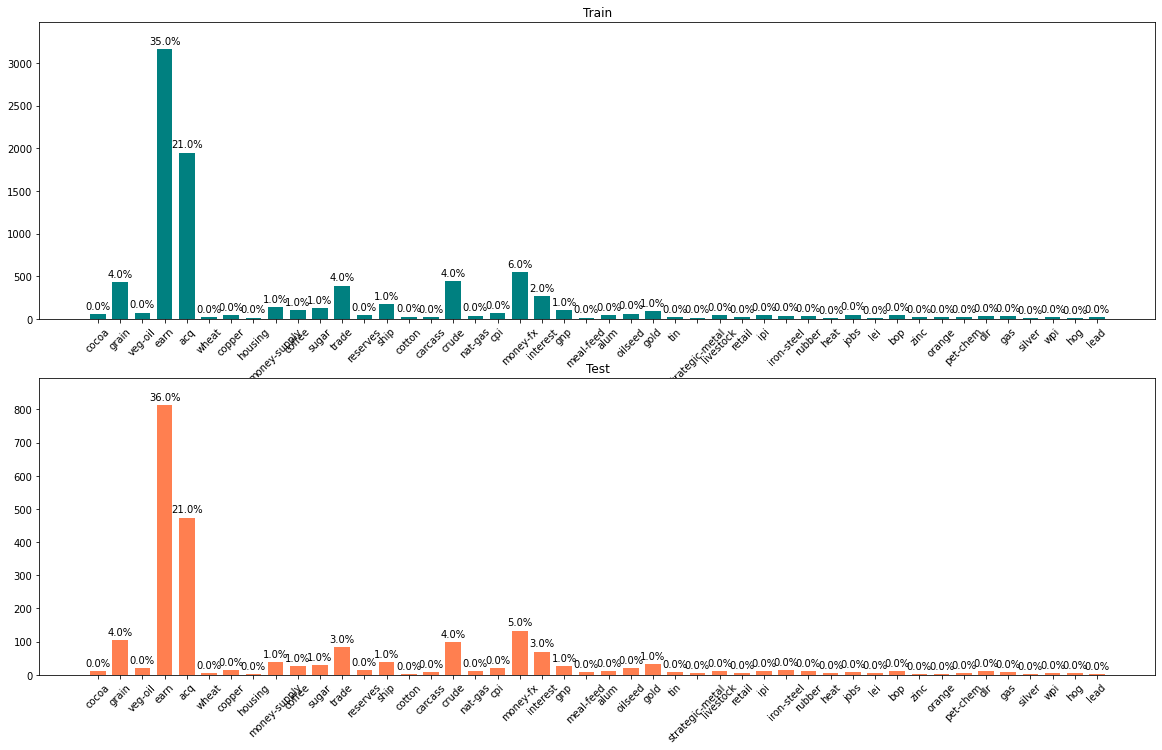

In [13]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

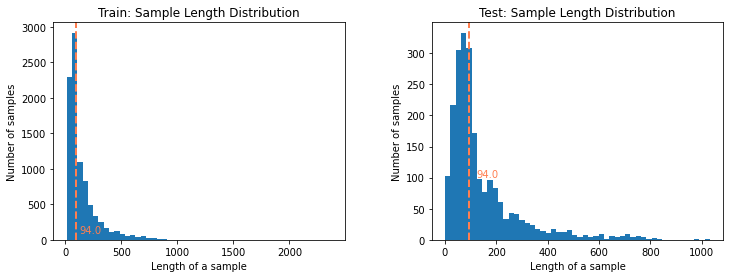

train：mean=144.54 variance=21261.74
test：mean=146.66 variance=21351.99


In [14]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))


通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [15]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,1211,550,225,99,70,30,27,25,9,2246
train,4834,2273,883,410,223,151,101,62,45,8982
合计,6045,2823,1108,509,293,181,128,87,54,11228


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,1209.215354,564.70057,221.639473,101.818133,58.610438,36.206448,25.60456,17.403099,10.801924,2246.0
train,4835.784646,2258.29943,886.360527,407.181867,234.389562,144.793552,102.39544,69.596901,43.198076,8982.0
合计,6045.000000,2823.00000,1108.000000,509.000000,293.000000,181.000000,128.00000,87.000000,54.000000,11228.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [16]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 9.355859347084184
critical_value = 15.50731305586545
p_value = 0.313170934470006



### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

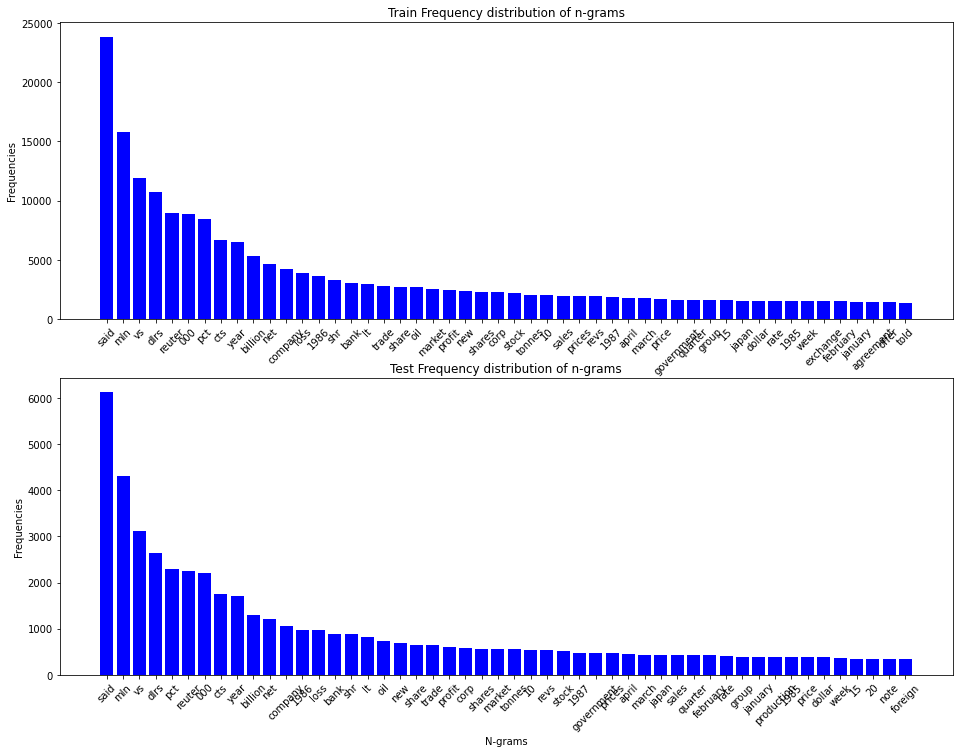

In [17]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [18]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 30978
Number of Vocabulary: 4676


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [19]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 95.6


可以看到这个比例大大小于15k，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下几个过程。
1. Standardization 
   
   文本标准化操作，去除一些不合规范的字符或单词等。比如：去除拼音和HTML标记
   
   
2. Tokenization

   把文本字符串拆分成Token。对于英文最常见的拆分方式是根据空格拆分
   
   
3. Vectorization

   把Token转化为向量。
   

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram + Preprocess

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [20]:
stop_words = params.stop_words if params.use_stop_words else None
generator = qtf.classification.NgramGenerator('ngram_preproess', standardize=qtf.text.standardize_text1,
                                              texts=train_texts, labels=train_labels, max_feature=params.max_features, 
                                              stop_words=stop_words)
ngram_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [21]:
data, labels = iter(ngram_datasets1.train_dataset).next()
print(type(data))
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(tf.sparse.to_dense(data), labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(np.any(item.numpy()>0), item.shape)

<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
(32, 10000) (32,)
---------------------------------------- earn ----------------------------------------
True (10000,)
---------------------------------------- crude ----------------------------------------
True (10000,)
---------------------------------------- ship ----------------------------------------
True (10000,)
---------------------------------------- earn ----------------------------------------
True (10000,)
---------------------------------------- jobs ----------------------------------------
True (10000,)


### Sequence + Preprocess

In [22]:
generator = qtf.classification.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                       texts=train_texts, max_features=params.max_features, 
                                       max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [23]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- earn ----------------------------------------
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

### N-gram + Process

In [24]:
generator = qtf.classification.LayerGenerator.get_ngram_layer(name='ngram_map', standardize=qtf.text.standardize_tf_text1, 
                                                        texts=train_texts, max_features=params.max_features)
ngram_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [25]:
data, labels = iter(ngram_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 10000) (32,)
---------------------------------------- earn ----------------------------------------
[67.5464  0.      0.     ...  0.      0.      0.    ] (10000,)
---------------------------------------- jobs ----------------------------------------
[129.89693     6.0434437   0.8312137 ...   0.          0.
   0.       ] (10000,)
---------------------------------------- acq ----------------------------------------
[228.61859     4.3167453   2.4936411 ...   0.          0.
   0.       ] (10000,)
---------------------------------------- earn ----------------------------------------
[0. 0. 0. ... 0. 0. 0.] (10000,)
---------------------------------------- cocoa ----------------------------------------
[77.938156   3.4533963  2.4936411 ...  0.         0.         0.       ] (10000,)


### Sequence + Process

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。

In [26]:
generator = qtf.classification.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                       standardize=qtf.text.standardize_tf_text1, 
                                                       texts=train_texts, 
                                                       max_features=params.max_features,
                                                       max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [27]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- acq ----------------------------------------
[4291 2377   49    1 4993   34  432    8   16  280    5   49  549 7647
  771  747    1    3 1202   18 1728 3560   97   49 5339  546   11  461
    1    3 4597    3  832    8  609 4291  519    6    1    1    8  644
    3 4291   10  294  352  101  576   20   49    1  771  747  120    3
    1 4032 1202   52 4240   37    8 1844    5    2  363 1387 1858    8
  280    5    1    3  117   16    1  238    5 9222 1202   34    8 5323
  771 5004    1    6    2   80  524  700 4441   11    2 5004  752    7
 1429   31    6   86  614   51  117  523   27 5323  172    5    2 1155
 1833    7    1 1544  232 4291   10 1155 1833  284   49    1 2239   43
  739  106  693   88 1272   60   28   26 2436   23    2   24  128   31
    6 4291  534    1  197   30 1870    8   24    5 5323  771    7  305
    4  129   42  673    4  197   30 1870    5    2  196  798  185   15
    0    0    0    0    0    0    0    0    0 

In [28]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2021-08-10 06:08:21,438: INFO: --------------------------------------------------------------------------------
2021-08-10 06:09:47,957: INFO: Loaded 1000000 word vectors. the vector size is 300
2021-08-10 06:09:47,979: INFO: embedding_matrix.shape: (10000, 300)
2021-08-10 06:09:47,980: INFO: match count: 9095
2021-08-10 06:09:47,980: INFO: missing word count: 905


上面结果可以看到，



##  模型

### MLP

#### mp1

2021-08-10 06:17:32,140: INFO: model_params.mlp1.dropout=0.6
2021-08-10 06:17:32,141: INFO: model_params.mlp1.layer_count=1
2021-08-10 06:17:32,141: INFO: model_params.mlp1.units=256
2021-08-10 06:17:32,174: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:17:32,185: INFO: learning_rate=0.001
2021-08-10 06:17:32,186: INFO: model_params.mlp1.clip_value=None
2021-08-10 06:17:32,194: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-te

SparseTensorSpec(TensorShape([32, 10000]), tf.float32)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 10000)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 46)                11822     
Total params: 2,572,078
Trainable params: 2,572,078
Non-trainable params:

2021-08-10 06:17:34,960: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 2/15
280/280 [==============================] - 1s 5ms/step - loss: 1.3311 - accuracy: 0.6954 - sparse_top_k_categorical_accuracy: 0.7751 - val_loss: 1.1410 - val_accuracy: 0.7453 - val_sparse_top_k_categorical_accuracy: 0.8272
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:37,159: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 3/15
280/280 [==============================] - 1s 4ms/step - loss: 1.0807 - accuracy: 0.7401 - sparse_top_k_categorical_accuracy: 0.8295 - val_loss: 0.9623 - val_accuracy: 0.7805 - val_sparse_top_k_categorical_accuracy: 0.8611
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:38,908: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 4/15
280/280 [==============================] - 1s 3ms/step - loss: 0.9275 - accuracy: 0.7753 - sparse_top_k_categorical_accuracy: 0.8664 - val_loss: 0.8648 - val_accuracy: 0.7947 - val_sparse_top_k_categorical_accuracy: 0.8807
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:40,455: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 5/15
280/280 [==============================] - 2s 6ms/step - loss: 0.8468 - accuracy: 0.7929 - sparse_top_k_categorical_accuracy: 0.8808 - val_loss: 0.8046 - val_accuracy: 0.8108 - val_sparse_top_k_categorical_accuracy: 0.8940
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:42,772: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 6/15
280/280 [==============================] - 2s 6ms/step - loss: 0.7703 - accuracy: 0.8102 - sparse_top_k_categorical_accuracy: 0.8941 - val_loss: 0.7712 - val_accuracy: 0.8166 - val_sparse_top_k_categorical_accuracy: 0.8963
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:45,355: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 7/15
280/280 [==============================] - 1s 4ms/step - loss: 0.7434 - accuracy: 0.8153 - sparse_top_k_categorical_accuracy: 0.9030 - val_loss: 0.7476 - val_accuracy: 0.8192 - val_sparse_top_k_categorical_accuracy: 0.9020
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:47,495: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 8/15
280/280 [==============================] - 2s 6ms/step - loss: 0.6869 - accuracy: 0.8213 - sparse_top_k_categorical_accuracy: 0.9090 - val_loss: 0.7359 - val_accuracy: 0.8224 - val_sparse_top_k_categorical_accuracy: 0.8989
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:50,041: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 9/15
280/280 [==============================] - 1s 5ms/step - loss: 0.6591 - accuracy: 0.8320 - sparse_top_k_categorical_accuracy: 0.9174 - val_loss: 0.7270 - val_accuracy: 0.8228 - val_sparse_top_k_categorical_accuracy: 0.9034
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:52,254: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 10/15
280/280 [==============================] - 1s 3ms/step - loss: 0.6344 - accuracy: 0.8360 - sparse_top_k_categorical_accuracy: 0.9203 - val_loss: 0.7250 - val_accuracy: 0.8224 - val_sparse_top_k_categorical_accuracy: 0.9007
Epoch 11/15
280/280 [==============================] - 1s 3ms/step - loss: 0.6225 - accuracy: 0.8396 - sparse_top_k_categorical_accuracy: 0.9176 - val_loss: 0.7180 - val_accuracy: 0.8277 - val_sparse_top_k_categorical_accuracy: 0.9047
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


2021-08-10 06:17:54,796: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets


Epoch 12/15
280/280 [==============================] - 1s 3ms/step - loss: 0.5964 - accuracy: 0.8420 - sparse_top_k_categorical_accuracy: 0.9246 - val_loss: 0.7176 - val_accuracy: 0.8264 - val_sparse_top_k_categorical_accuracy: 0.9052
Epoch 13/15
280/280 [==============================] - 1s 3ms/step - loss: 0.5869 - accuracy: 0.8464 - sparse_top_k_categorical_accuracy: 0.9271 - val_loss: 0.7212 - val_accuracy: 0.8255 - val_sparse_top_k_categorical_accuracy: 0.9069
Epoch 14/15
280/280 [==============================] - 1s 3ms/step - loss: 0.5748 - accuracy: 0.8497 - sparse_top_k_categorical_accuracy: 0.9276 - val_loss: 0.7210 - val_accuracy: 0.8250 - val_sparse_top_k_categorical_accuracy: 0.9069
Epoch 15/15
280/280 [==============================] - 1s 3ms/step - loss: 0.5515 - accuracy: 0.8546 - sparse_top_k_categorical_accuracy: 0.9316 - val_loss: 0.7201 - val_accuracy: 0.8286 - val_sparse_top_k_categorical_accuracy: 0.9065
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.git

2021-08-10 06:17:58,850: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1/assets
2021-08-10 06:17:59,378: INFO: finish training [elapsed time: 27.18 seconds]


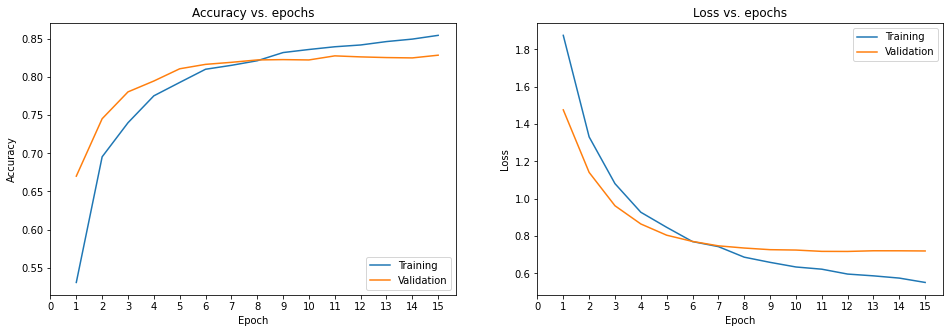

2021-08-10 06:17:59,853: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 06:18:05,060: INFO: test loss:0.7201
2021-08-10 06:18:05,061: INFO: test accuracy:0.8286
2021-08-10 06:18:05,061: INFO: test sparse_top_k_categorical_accuracy:0.9065
2021-08-10 06:18:05,062: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:18:05,064: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:18:05,065: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator
2021-08-10 06:18:05,179: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


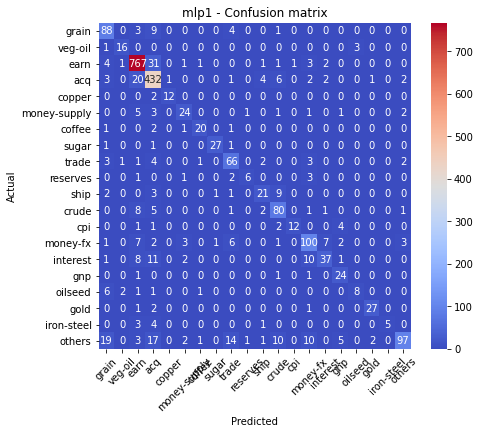

----------------------------------------sample analysis----------------------------------------
<class 'list'>
----------------------------------------1. crude----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


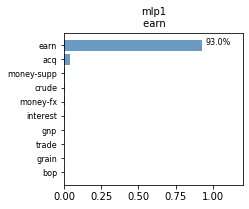

----------------------------------------2. money-fx----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


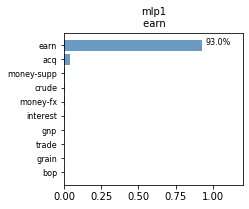

----------------------------------------3. grain----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


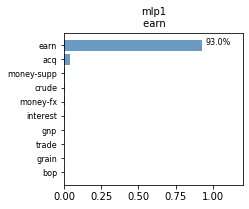

----------------------------------------4. zinc----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


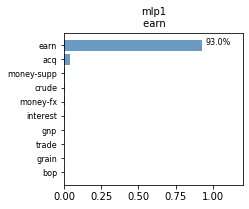

----------------------------------------5. acq----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


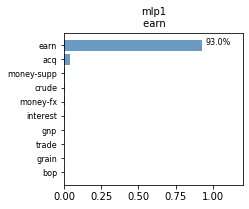

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769


In [35]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets1, model_results=model_results)
model = qtf.classification.text_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True)

#### mlp2

2021-08-10 06:18:10,982: INFO: model_params.mlp2.dropout=0.6
2021-08-10 06:18:10,983: INFO: model_params.mlp2.layer_count=1
2021-08-10 06:18:10,983: INFO: model_params.mlp2.units=256
2021-08-10 06:18:11,004: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:18:11,011: INFO: learning_rate=0.001
2021-08-10 06:18:11,011: INFO: model_params.mlp2.clip_value=None
2021-08-10 06:18:11,017: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-te

TensorSpec(shape=(32, 10000), dtype=tf.float32, name=None)
Model: "mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 46)                11822     
Total params: 2,572,078
Trainable params: 2,572,078
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
280/280 [==============================] - 6s 19

2021-08-10 06:18:17,508: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


Epoch 2/15
280/280 [==============================] - 1s 3ms/step - loss: 1.4561 - accuracy: 0.6821 - sparse_top_k_categorical_accuracy: 0.7656 - val_loss: 1.3082 - val_accuracy: 0.6848 - val_sparse_top_k_categorical_accuracy: 0.7596
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


2021-08-10 06:18:19,125: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


Epoch 3/15
280/280 [==============================] - 1s 3ms/step - loss: 1.2717 - accuracy: 0.7239 - sparse_top_k_categorical_accuracy: 0.8011 - val_loss: 1.3123 - val_accuracy: 0.6736 - val_sparse_top_k_categorical_accuracy: 0.7560
Epoch 4/15
280/280 [==============================] - 1s 3ms/step - loss: 1.1963 - accuracy: 0.7307 - sparse_top_k_categorical_accuracy: 0.8206 - val_loss: 1.1829 - val_accuracy: 0.7204 - val_sparse_top_k_categorical_accuracy: 0.8005
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


2021-08-10 06:18:21,630: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


Epoch 5/15
280/280 [==============================] - 1s 3ms/step - loss: 1.1044 - accuracy: 0.7538 - sparse_top_k_categorical_accuracy: 0.8337 - val_loss: 1.0918 - val_accuracy: 0.7471 - val_sparse_top_k_categorical_accuracy: 0.8264
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


2021-08-10 06:18:23,193: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


Epoch 6/15
280/280 [==============================] - 1s 3ms/step - loss: 1.0266 - accuracy: 0.7706 - sparse_top_k_categorical_accuracy: 0.8512 - val_loss: 1.1349 - val_accuracy: 0.7231 - val_sparse_top_k_categorical_accuracy: 0.8081
Epoch 7/15
280/280 [==============================] - 1s 3ms/step - loss: 0.9958 - accuracy: 0.7747 - sparse_top_k_categorical_accuracy: 0.8596 - val_loss: 1.0634 - val_accuracy: 0.7578 - val_sparse_top_k_categorical_accuracy: 0.8406
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


2021-08-10 06:18:25,690: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


Epoch 8/15
280/280 [==============================] - 1s 3ms/step - loss: 0.9089 - accuracy: 0.7887 - sparse_top_k_categorical_accuracy: 0.8689 - val_loss: 1.0636 - val_accuracy: 0.7573 - val_sparse_top_k_categorical_accuracy: 0.8393
Epoch 9/15
280/280 [==============================] - 1s 3ms/step - loss: 0.8866 - accuracy: 0.7913 - sparse_top_k_categorical_accuracy: 0.8750 - val_loss: 1.1030 - val_accuracy: 0.7329 - val_sparse_top_k_categorical_accuracy: 0.8224
Epoch 10/15
280/280 [==============================] - 1s 3ms/step - loss: 0.8614 - accuracy: 0.7954 - sparse_top_k_categorical_accuracy: 0.8809 - val_loss: 1.0329 - val_accuracy: 0.7663 - val_sparse_top_k_categorical_accuracy: 0.8477
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


2021-08-10 06:18:29,197: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


Epoch 11/15
280/280 [==============================] - 1s 3ms/step - loss: 0.8473 - accuracy: 0.8065 - sparse_top_k_categorical_accuracy: 0.8869 - val_loss: 1.0245 - val_accuracy: 0.7649 - val_sparse_top_k_categorical_accuracy: 0.8473
Epoch 12/15
280/280 [==============================] - 1s 3ms/step - loss: 0.8247 - accuracy: 0.8056 - sparse_top_k_categorical_accuracy: 0.8838 - val_loss: 1.0542 - val_accuracy: 0.7569 - val_sparse_top_k_categorical_accuracy: 0.8375
Epoch 13/15
280/280 [==============================] - 1s 3ms/step - loss: 0.8218 - accuracy: 0.8077 - sparse_top_k_categorical_accuracy: 0.8871 - val_loss: 1.0587 - val_accuracy: 0.7507 - val_sparse_top_k_categorical_accuracy: 0.8344
Epoch 14/15
280/280 [==============================] - 1s 3ms/step - loss: 0.7853 - accuracy: 0.8087 - sparse_top_k_categorical_accuracy: 0.8907 - val_loss: 1.0440 - val_accuracy: 0.7707 - val_sparse_top_k_categorical_accuracy: 0.8531
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.git

2021-08-10 06:18:33,470: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2/assets


Epoch 15/15
280/280 [==============================] - 1s 3ms/step - loss: 0.7896 - accuracy: 0.8127 - sparse_top_k_categorical_accuracy: 0.8931 - val_loss: 1.0195 - val_accuracy: 0.7680 - val_sparse_top_k_categorical_accuracy: 0.8517


2021-08-10 06:18:34,862: INFO: finish training [elapsed time: 23.84 seconds]


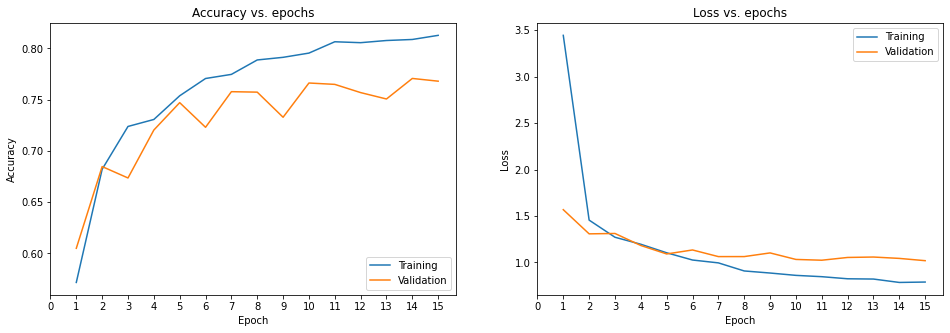

2021-08-10 06:18:35,322: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------


2021-08-10 06:18:42,544: INFO: test loss:1.0440
2021-08-10 06:18:42,545: INFO: test accuracy:0.7707
2021-08-10 06:18:42,546: INFO: test sparse_top_k_categorical_accuracy:0.8531
2021-08-10 06:18:42,547: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:18:42,549: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:18:42,550: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:18:42,556: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:18:42,600: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.layer/assets


2021-08-10 06:18:43,495: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.layer/assets
2021-08-10 06:18:43,518: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.generator
2021-08-10 06:18:43,519: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:18:43,862: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


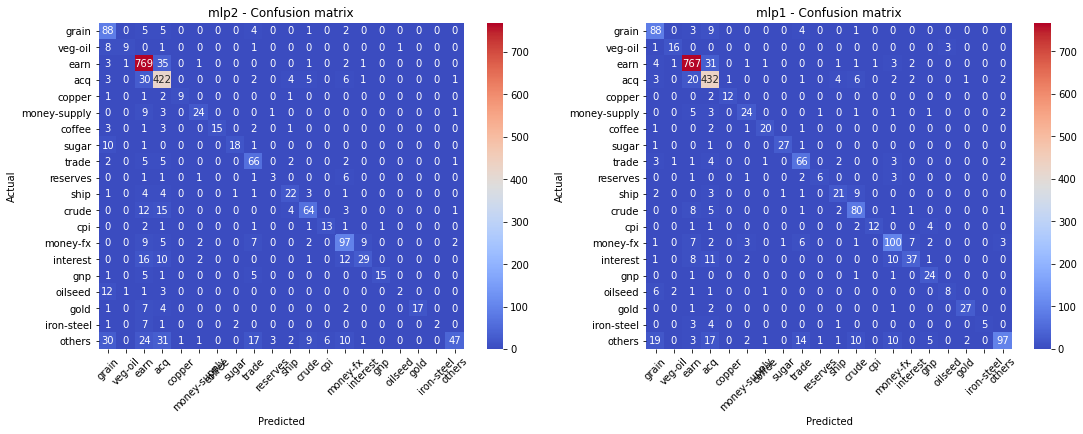

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611


In [36]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets2, model_results=model_results)
model = qtf.classification.text_models.mlp1(helper, name='mlp2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

2021-08-10 06:18:52,680: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------


2021-08-10 06:18:59,401: INFO: test loss:1.0440
2021-08-10 06:18:59,402: INFO: test accuracy:0.7707
2021-08-10 06:18:59,402: INFO: test sparse_top_k_categorical_accuracy:0.8531
2021-08-10 06:18:59,404: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:18:59,405: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:18:59,406: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:18:59,411: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:18:59,454: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.layer/assets


2021-08-10 06:19:00,047: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.layer/assets
2021-08-10 06:19:00,069: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.generator
2021-08-10 06:19:00,069: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:19:00,404: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


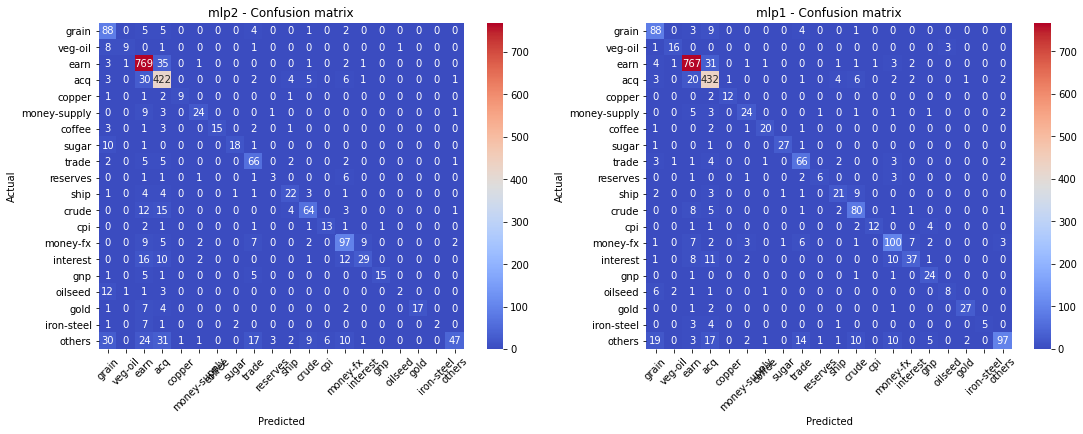

2021-08-10 06:19:08,809: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------sample analysis----------------------------------------


2021-08-10 06:19:09,214: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


<class 'list'>
----------------------------------------1. money-fx----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


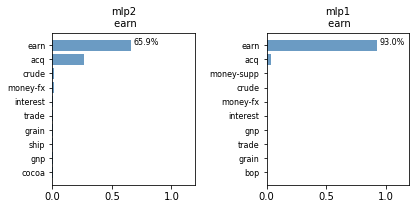

----------------------------------------2. earn----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


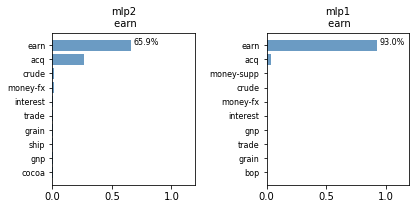

----------------------------------------3. interest----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


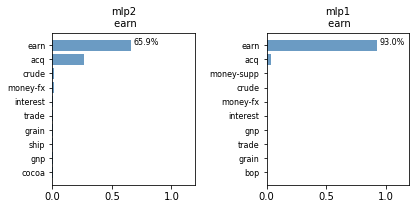

----------------------------------------4. money-supply----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


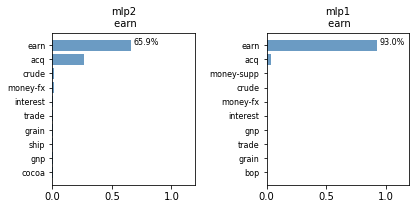

----------------------------------------5. earn----------------------------------------
philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yulo told reuters a survey during the current milling season which ends next month showed the 1986 87 estimate would almost certainly be met he said at least 1 2 mln tonnes of the 1987 88 crop would be earmarked for domestic consumption yulo said about 130 000 tonnes would be set aside for the u s sugar quota 150 000 tonnes for strategic reserves and 50 000 tonnes would be sold on the world market he said if the government approved a long standing sra recommendation to manufacture ethanol the project would take up another 150 000 tonnes slightly raising the target the government for its own reasons has been delaying approval of the project but we expect it to come through by july yulo said ethan

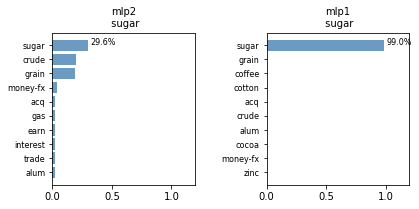

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611


In [37]:
helper.model_summary(model, history, show_sample_analysis=True)

### Embedding

#### embedding

2021-08-10 06:19:13,526: INFO: model_params.embedding.dropout=0.4
2021-08-10 06:19:13,527: INFO: model_params.embedding.embedding_dim=200
2021-08-10 06:19:13,558: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:19:13,566: INFO: learning_rate=0.001
2021-08-10 06:19:13,567: INFO: model_params.embedding.clip_value=None
2021-08-10 06:19:13,573: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reut

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 200)     2000000     input_6[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 200)          0           embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 200)          0           embedding[0][0]                  
___________________________________

2021-08-10 06:19:19,474: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 2/15
280/280 [==============================] - 4s 14ms/step - loss: 1.3942 - accuracy: 0.6887 - sparse_top_k_categorical_accuracy: 0.7569 - val_loss: 1.2792 - val_accuracy: 0.7150 - val_sparse_top_k_categorical_accuracy: 0.7876
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


2021-08-10 06:19:24,134: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 3/15
280/280 [==============================] - 4s 14ms/step - loss: 1.0481 - accuracy: 0.7629 - sparse_top_k_categorical_accuracy: 0.8295 - val_loss: 1.0574 - val_accuracy: 0.7756 - val_sparse_top_k_categorical_accuracy: 0.8375
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


2021-08-10 06:19:28,774: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 4/15
280/280 [==============================] - 4s 14ms/step - loss: 0.8294 - accuracy: 0.8142 - sparse_top_k_categorical_accuracy: 0.8744 - val_loss: 0.9282 - val_accuracy: 0.7934 - val_sparse_top_k_categorical_accuracy: 0.8584
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


2021-08-10 06:19:33,405: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 5/15
280/280 [==============================] - 4s 14ms/step - loss: 0.6810 - accuracy: 0.8442 - sparse_top_k_categorical_accuracy: 0.9015 - val_loss: 0.8516 - val_accuracy: 0.8045 - val_sparse_top_k_categorical_accuracy: 0.8762
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


2021-08-10 06:19:38,025: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 6/15
280/280 [==============================] - 4s 14ms/step - loss: 0.5689 - accuracy: 0.8662 - sparse_top_k_categorical_accuracy: 0.9234 - val_loss: 0.8028 - val_accuracy: 0.8152 - val_sparse_top_k_categorical_accuracy: 0.8887
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


2021-08-10 06:19:42,671: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 7/15
280/280 [==============================] - 4s 14ms/step - loss: 0.4778 - accuracy: 0.8896 - sparse_top_k_categorical_accuracy: 0.9443 - val_loss: 0.7717 - val_accuracy: 0.8237 - val_sparse_top_k_categorical_accuracy: 0.8972
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


2021-08-10 06:19:47,569: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 8/15
280/280 [==============================] - 4s 14ms/step - loss: 0.4028 - accuracy: 0.9078 - sparse_top_k_categorical_accuracy: 0.9592 - val_loss: 0.7535 - val_accuracy: 0.8232 - val_sparse_top_k_categorical_accuracy: 0.8958
Epoch 9/15
280/280 [==============================] - 4s 14ms/step - loss: 0.3413 - accuracy: 0.9205 - sparse_top_k_categorical_accuracy: 0.9683 - val_loss: 0.7452 - val_accuracy: 0.8246 - val_sparse_top_k_categorical_accuracy: 0.8994
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


2021-08-10 06:19:56,458: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 10/15
280/280 [==============================] - 4s 14ms/step - loss: 0.2910 - accuracy: 0.9301 - sparse_top_k_categorical_accuracy: 0.9743 - val_loss: 0.7441 - val_accuracy: 0.8259 - val_sparse_top_k_categorical_accuracy: 0.9016
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


2021-08-10 06:20:01,068: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding/assets


Epoch 11/15
280/280 [==============================] - 4s 15ms/step - loss: 0.2501 - accuracy: 0.9372 - sparse_top_k_categorical_accuracy: 0.9808 - val_loss: 0.7483 - val_accuracy: 0.8246 - val_sparse_top_k_categorical_accuracy: 0.9029
Epoch 12/15
280/280 [==============================] - 4s 15ms/step - loss: 0.2173 - accuracy: 0.9439 - sparse_top_k_categorical_accuracy: 0.9844 - val_loss: 0.7564 - val_accuracy: 0.8219 - val_sparse_top_k_categorical_accuracy: 0.9012
Epoch 13/15
280/280 [==============================] - 4s 14ms/step - loss: 0.1911 - accuracy: 0.9474 - sparse_top_k_categorical_accuracy: 0.9876 - val_loss: 0.7681 - val_accuracy: 0.8228 - val_sparse_top_k_categorical_accuracy: 0.9016
Epoch 14/15
280/280 [==============================] - 4s 14ms/step - loss: 0.1702 - accuracy: 0.9500 - sparse_top_k_categorical_accuracy: 0.9901 - val_loss: 0.7815 - val_accuracy: 0.8210 - val_sparse_top_k_categorical_accuracy: 0.9025
Epoch 15/15
280/280 [==============================] - 4

2021-08-10 06:20:21,887: INFO: finish training [elapsed time: 68.31 seconds]


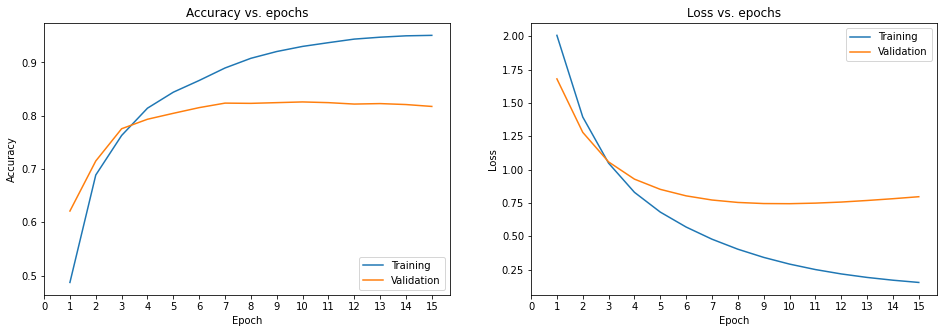

2021-08-10 06:20:22,350: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding
----------------------------------------evaluate----------------------------------------


2021-08-10 06:20:28,763: INFO: test loss:0.7441
2021-08-10 06:20:28,764: INFO: test accuracy:0.8259
2021-08-10 06:20:28,765: INFO: test sparse_top_k_categorical_accuracy:0.9016
2021-08-10 06:20:28,766: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:20:28,767: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:20:28,768: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:20:28,772: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:20:28,818: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets


2021-08-10 06:20:29,459: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets
2021-08-10 06:20:29,481: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator
2021-08-10 06:20:29,482: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:20:29,818: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


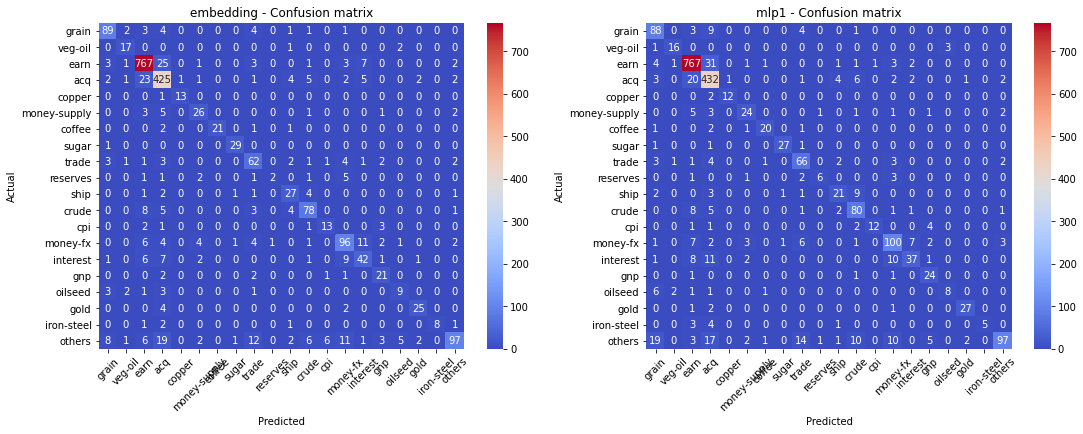

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
3,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611


In [38]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.embedding1(helper, name='embedding')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### embedding_ft

2021-08-10 06:20:38,412: INFO: model_params.embedding_ft.dropout=0.4
2021-08-10 06:20:38,412: INFO: model_params.embedding_ft.embedding_dim=200
2021-08-10 06:20:38,444: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:20:38,451: INFO: learning_rate=0.001
2021-08-10 06:20:38,452: INFO: model_params.embedding_ft.clip_value=None
2021-08-10 06:20:38,457: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/ou

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
10000 300
Model: "embedding_ft"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     3000000     input_8[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 300)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 300)          0           embedding_1[0][0]                
______________________

2021-08-10 06:20:41,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 2/15
280/280 [==============================] - 2s 6ms/step - loss: 1.8519 - accuracy: 0.5328 - sparse_top_k_categorical_accuracy: 0.6354 - val_loss: 1.7943 - val_accuracy: 0.5565 - val_sparse_top_k_categorical_accuracy: 0.6496
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:20:43,789: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 3/15
280/280 [==============================] - 2s 6ms/step - loss: 1.6927 - accuracy: 0.5757 - sparse_top_k_categorical_accuracy: 0.6814 - val_loss: 1.6728 - val_accuracy: 0.5948 - val_sparse_top_k_categorical_accuracy: 0.6834
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:20:46,153: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 4/15
280/280 [==============================] - 2s 6ms/step - loss: 1.5738 - accuracy: 0.6142 - sparse_top_k_categorical_accuracy: 0.7124 - val_loss: 1.5791 - val_accuracy: 0.6238 - val_sparse_top_k_categorical_accuracy: 0.7102
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:20:48,624: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 5/15
280/280 [==============================] - 2s 6ms/step - loss: 1.4784 - accuracy: 0.6433 - sparse_top_k_categorical_accuracy: 0.7354 - val_loss: 1.5032 - val_accuracy: 0.6460 - val_sparse_top_k_categorical_accuracy: 0.7346
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:20:50,934: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 6/15
280/280 [==============================] - 2s 6ms/step - loss: 1.3994 - accuracy: 0.6623 - sparse_top_k_categorical_accuracy: 0.7533 - val_loss: 1.4399 - val_accuracy: 0.6634 - val_sparse_top_k_categorical_accuracy: 0.7533
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:20:53,217: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 7/15
280/280 [==============================] - 2s 6ms/step - loss: 1.3323 - accuracy: 0.6811 - sparse_top_k_categorical_accuracy: 0.7710 - val_loss: 1.3860 - val_accuracy: 0.6808 - val_sparse_top_k_categorical_accuracy: 0.7654
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:20:55,464: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 8/15
280/280 [==============================] - 2s 6ms/step - loss: 1.2745 - accuracy: 0.6948 - sparse_top_k_categorical_accuracy: 0.7877 - val_loss: 1.3395 - val_accuracy: 0.6923 - val_sparse_top_k_categorical_accuracy: 0.7743
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:20:57,746: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 9/15
280/280 [==============================] - 2s 6ms/step - loss: 1.2240 - accuracy: 0.7108 - sparse_top_k_categorical_accuracy: 0.8016 - val_loss: 1.2990 - val_accuracy: 0.6990 - val_sparse_top_k_categorical_accuracy: 0.7890
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:21:00,082: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 10/15
280/280 [==============================] - 2s 6ms/step - loss: 1.1794 - accuracy: 0.7223 - sparse_top_k_categorical_accuracy: 0.8109 - val_loss: 1.2633 - val_accuracy: 0.7021 - val_sparse_top_k_categorical_accuracy: 0.7916
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:21:02,354: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 11/15
280/280 [==============================] - 2s 6ms/step - loss: 1.1398 - accuracy: 0.7310 - sparse_top_k_categorical_accuracy: 0.8214 - val_loss: 1.2317 - val_accuracy: 0.7133 - val_sparse_top_k_categorical_accuracy: 0.8023
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:21:04,760: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 12/15
280/280 [==============================] - 2s 6ms/step - loss: 1.1042 - accuracy: 0.7408 - sparse_top_k_categorical_accuracy: 0.8304 - val_loss: 1.2035 - val_accuracy: 0.7173 - val_sparse_top_k_categorical_accuracy: 0.8090
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:21:07,413: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 13/15
280/280 [==============================] - 2s 6ms/step - loss: 1.0722 - accuracy: 0.7481 - sparse_top_k_categorical_accuracy: 0.8358 - val_loss: 1.1781 - val_accuracy: 0.7240 - val_sparse_top_k_categorical_accuracy: 0.8143
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:21:09,783: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 14/15
280/280 [==============================] - 2s 6ms/step - loss: 1.0431 - accuracy: 0.7555 - sparse_top_k_categorical_accuracy: 0.8414 - val_loss: 1.1553 - val_accuracy: 0.7284 - val_sparse_top_k_categorical_accuracy: 0.8179
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:21:12,175: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


Epoch 15/15
280/280 [==============================] - 2s 6ms/step - loss: 1.0165 - accuracy: 0.7626 - sparse_top_k_categorical_accuracy: 0.8478 - val_loss: 1.1345 - val_accuracy: 0.7311 - val_sparse_top_k_categorical_accuracy: 0.8206
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets


2021-08-10 06:21:14,583: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft/assets
2021-08-10 06:21:15,109: INFO: finish training [elapsed time: 36.65 seconds]


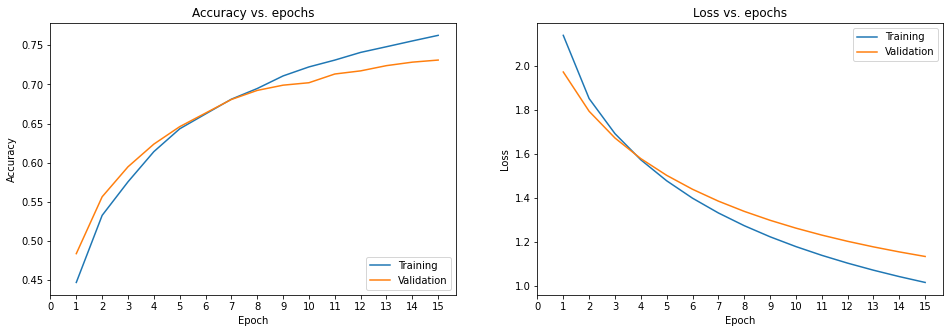

2021-08-10 06:21:15,583: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding_ft
----------------------------------------evaluate----------------------------------------


2021-08-10 06:21:22,401: INFO: test loss:1.1345
2021-08-10 06:21:22,402: INFO: test accuracy:0.7311
2021-08-10 06:21:22,403: INFO: test sparse_top_k_categorical_accuracy:0.8206
2021-08-10 06:21:22,405: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:21:22,407: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:21:22,408: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:21:22,413: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:21:22,456: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets


2021-08-10 06:21:23,047: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets
2021-08-10 06:21:23,069: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator
2021-08-10 06:21:23,070: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:21:23,405: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


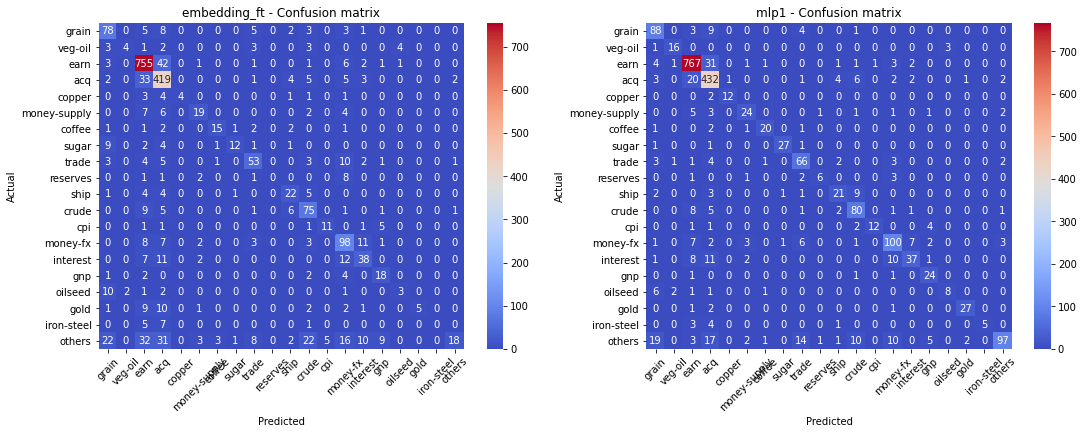

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
3,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611
4,embedding_ft,27646,36.1,1.0055,1.1345,0.7708,0.7311,0.8497,0.8206,0.9719,0.9579


In [39]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.embedding1(helper, name='embedding_ft',
                                             embedding_matrix=embedding_matrix_fasttext,
                                             is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### sepCNN

#### sepcnn

2021-08-10 06:21:31,982: INFO: model_params.sepcnn.dropout=0.4
2021-08-10 06:21:32,055: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:21:32,061: INFO: learning_rate=0.001
2021-08-10 06:21:32,062: INFO: model_params.sepcnn.clip_value=None
2021-08-10 06:21:32,068: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn
2021-08-10 06:21:32,070: INFO: model_params.sepcn

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 200)          2000200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dropo

2021-08-10 06:21:42,140: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 2/10
280/280 [==============================] - 6s 21ms/step - loss: 1.9370 - accuracy: 0.5022 - sparse_top_k_categorical_accuracy: 0.6241 - val_loss: 1.8510 - val_accuracy: 0.5423 - val_sparse_top_k_categorical_accuracy: 0.6496
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


2021-08-10 06:21:49,202: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 3/10
280/280 [==============================] - 6s 21ms/step - loss: 1.7418 - accuracy: 0.5816 - sparse_top_k_categorical_accuracy: 0.6702 - val_loss: 1.6801 - val_accuracy: 0.6247 - val_sparse_top_k_categorical_accuracy: 0.6972
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


2021-08-10 06:21:56,158: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 4/10
280/280 [==============================] - 6s 23ms/step - loss: 1.5254 - accuracy: 0.6503 - sparse_top_k_categorical_accuracy: 0.7186 - val_loss: 1.5291 - val_accuracy: 0.6647 - val_sparse_top_k_categorical_accuracy: 0.7240
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


2021-08-10 06:22:04,094: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 5/10
280/280 [==============================] - 7s 24ms/step - loss: 1.3787 - accuracy: 0.6878 - sparse_top_k_categorical_accuracy: 0.7446 - val_loss: 1.4847 - val_accuracy: 0.6736 - val_sparse_top_k_categorical_accuracy: 0.7333
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


2021-08-10 06:22:11,969: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 6/10
280/280 [==============================] - 7s 24ms/step - loss: 1.2764 - accuracy: 0.7047 - sparse_top_k_categorical_accuracy: 0.7651 - val_loss: 1.4425 - val_accuracy: 0.6834 - val_sparse_top_k_categorical_accuracy: 0.7440
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


2021-08-10 06:22:19,802: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 7/10
280/280 [==============================] - 7s 24ms/step - loss: 1.1816 - accuracy: 0.7166 - sparse_top_k_categorical_accuracy: 0.7783 - val_loss: 1.4341 - val_accuracy: 0.6870 - val_sparse_top_k_categorical_accuracy: 0.7569
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


2021-08-10 06:22:27,735: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 8/10
280/280 [==============================] - 7s 24ms/step - loss: 1.1103 - accuracy: 0.7300 - sparse_top_k_categorical_accuracy: 0.7953 - val_loss: 1.3943 - val_accuracy: 0.6972 - val_sparse_top_k_categorical_accuracy: 0.7703
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


2021-08-10 06:22:35,577: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 9/10
280/280 [==============================] - 7s 24ms/step - loss: 1.0285 - accuracy: 0.7479 - sparse_top_k_categorical_accuracy: 0.8117 - val_loss: 1.4052 - val_accuracy: 0.6986 - val_sparse_top_k_categorical_accuracy: 0.7760
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


2021-08-10 06:22:43,389: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn/assets


Epoch 10/10
280/280 [==============================] - 6s 20ms/step - loss: 0.9558 - accuracy: 0.7609 - sparse_top_k_categorical_accuracy: 0.8298 - val_loss: 1.4153 - val_accuracy: 0.6986 - val_sparse_top_k_categorical_accuracy: 0.7823


2021-08-10 06:22:49,679: INFO: finish training [elapsed time: 77.61 seconds]


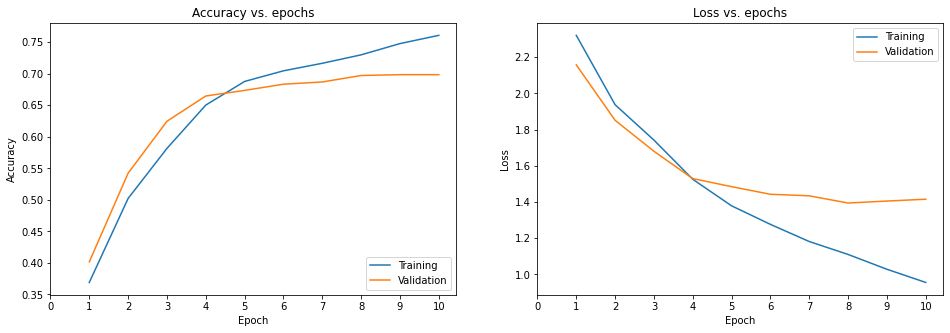

2021-08-10 06:22:50,365: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn
----------------------------------------evaluate----------------------------------------


2021-08-10 06:22:56,759: INFO: test loss:1.4052
2021-08-10 06:22:56,760: INFO: test accuracy:0.6986
2021-08-10 06:22:56,760: INFO: test sparse_top_k_categorical_accuracy:0.7760
2021-08-10 06:22:56,762: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:22:56,763: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:22:56,764: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:22:56,768: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:22:56,810: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets


2021-08-10 06:22:57,391: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets
2021-08-10 06:22:57,412: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator
2021-08-10 06:22:57,413: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:22:57,734: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


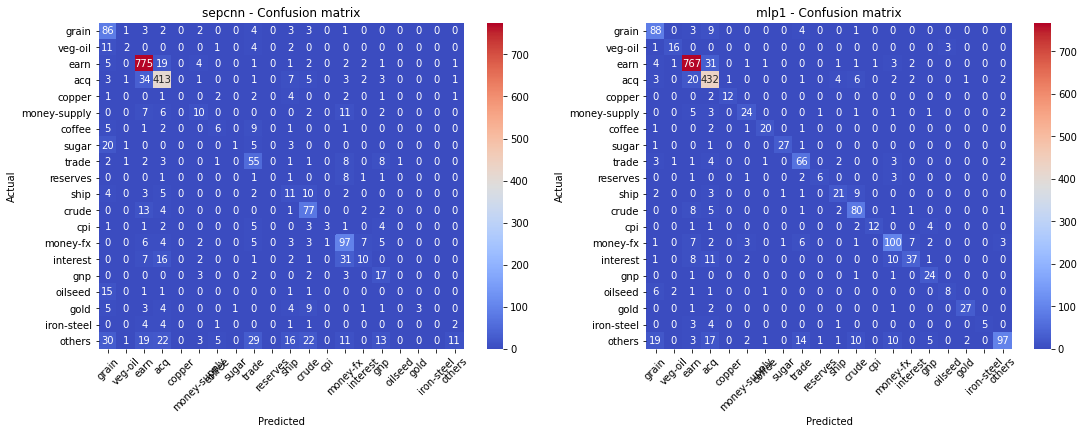

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
3,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611
4,embedding_ft,27646,36.1,1.0055,1.1345,0.7708,0.7311,0.8497,0.8206,0.9719,0.9579
5,sepcnn,2049358,77.1,0.8618,1.4052,0.7857,0.6986,0.8470,0.7760,0.9678,0.9180


In [40]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.sepcnn1(helper, name='sepcnn', blocks=1)
# when bolcks=2, the model can't converg
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### sepcnn_ft

2021-08-10 06:23:05,662: INFO: model_params.sepcnn_ft.dropout=0.4
2021-08-10 06:23:05,731: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:23:05,737: INFO: learning_rate=0.001
2021-08-10 06:23:05,738: INFO: model_params.sepcnn_ft.clip_value=None
2021-08-10 06:23:05,743: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft
2021-08-10 06:23:05,746: INFO: model_par

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "sepcnn_ft"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 500, 128)          39428     
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dr

2021-08-10 06:23:12,516: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 2/10
280/280 [==============================] - 5s 16ms/step - loss: 1.7812 - accuracy: 0.5713 - sparse_top_k_categorical_accuracy: 0.6525 - val_loss: 1.6742 - val_accuracy: 0.6282 - val_sparse_top_k_categorical_accuracy: 0.7079
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:23:18,195: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 3/10
280/280 [==============================] - 5s 16ms/step - loss: 1.6056 - accuracy: 0.6336 - sparse_top_k_categorical_accuracy: 0.7145 - val_loss: 1.5232 - val_accuracy: 0.6581 - val_sparse_top_k_categorical_accuracy: 0.7297
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:23:23,947: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 4/10
280/280 [==============================] - 5s 16ms/step - loss: 1.4677 - accuracy: 0.6677 - sparse_top_k_categorical_accuracy: 0.7426 - val_loss: 1.4423 - val_accuracy: 0.6656 - val_sparse_top_k_categorical_accuracy: 0.7413
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:23:29,650: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 5/10
280/280 [==============================] - 5s 16ms/step - loss: 1.4038 - accuracy: 0.6797 - sparse_top_k_categorical_accuracy: 0.7515 - val_loss: 1.3853 - val_accuracy: 0.6776 - val_sparse_top_k_categorical_accuracy: 0.7582
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:23:35,360: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 6/10
280/280 [==============================] - 5s 16ms/step - loss: 1.3396 - accuracy: 0.6905 - sparse_top_k_categorical_accuracy: 0.7695 - val_loss: 1.3249 - val_accuracy: 0.6919 - val_sparse_top_k_categorical_accuracy: 0.7645
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:23:41,017: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 7/10
280/280 [==============================] - 5s 16ms/step - loss: 1.2989 - accuracy: 0.7003 - sparse_top_k_categorical_accuracy: 0.7754 - val_loss: 1.2905 - val_accuracy: 0.7017 - val_sparse_top_k_categorical_accuracy: 0.7747
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:23:47,041: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 8/10
280/280 [==============================] - 5s 16ms/step - loss: 1.2564 - accuracy: 0.7068 - sparse_top_k_categorical_accuracy: 0.7895 - val_loss: 1.2512 - val_accuracy: 0.7155 - val_sparse_top_k_categorical_accuracy: 0.7832
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:23:52,762: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 9/10
280/280 [==============================] - 5s 16ms/step - loss: 1.2114 - accuracy: 0.7166 - sparse_top_k_categorical_accuracy: 0.7958 - val_loss: 1.2206 - val_accuracy: 0.7231 - val_sparse_top_k_categorical_accuracy: 0.7916
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:23:58,438: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


Epoch 10/10
280/280 [==============================] - 5s 16ms/step - loss: 1.1914 - accuracy: 0.7224 - sparse_top_k_categorical_accuracy: 0.7999 - val_loss: 1.1973 - val_accuracy: 0.7275 - val_sparse_top_k_categorical_accuracy: 0.7961
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets


2021-08-10 06:24:04,120: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft/assets
2021-08-10 06:24:04,662: INFO: finish training [elapsed time: 58.91 seconds]


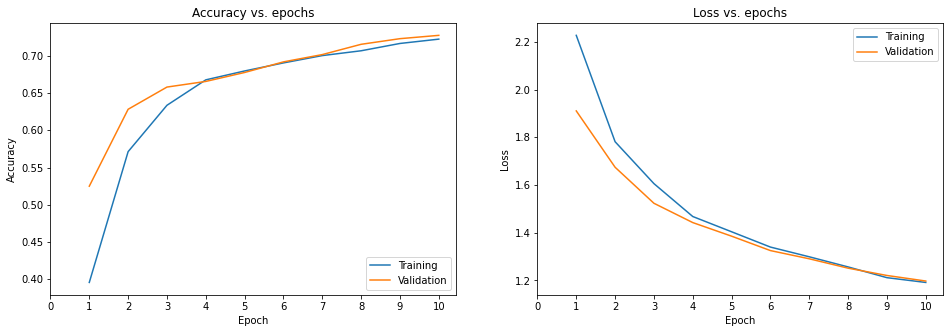

2021-08-10 06:24:05,061: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sepcnn_ft
----------------------------------------evaluate----------------------------------------


2021-08-10 06:24:12,387: INFO: test loss:1.1973
2021-08-10 06:24:12,387: INFO: test accuracy:0.7275
2021-08-10 06:24:12,388: INFO: test sparse_top_k_categorical_accuracy:0.7961
2021-08-10 06:24:12,389: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:24:12,391: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:24:12,391: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:24:12,396: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:24:12,445: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets


2021-08-10 06:24:13,043: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets
2021-08-10 06:24:13,064: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator
2021-08-10 06:24:13,065: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:24:13,396: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


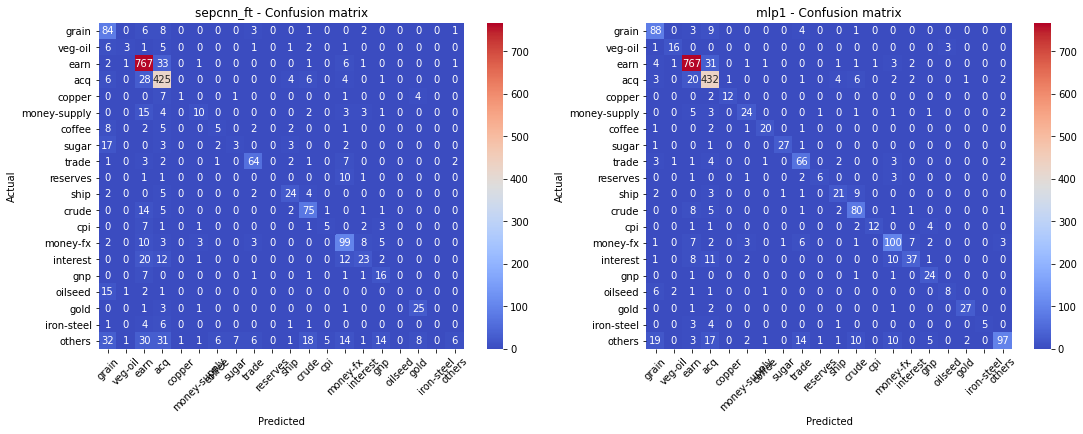

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
3,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611
4,embedding_ft,27646,36.1,1.0055,1.1345,0.7708,0.7311,0.8497,0.8206,0.9719,0.9579
5,sepcnn_ft,62258,58.4,1.0836,1.1973,0.7449,0.7275,0.8172,0.7961,0.9508,0.9462
6,sepcnn,2049358,77.1,0.8618,1.4052,0.7857,0.6986,0.8470,0.7760,0.9678,0.9180


In [41]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.sepcnn1(helper, name='sepcnn_ft', blocks=1,
                                          embedding_matrix=embedding_matrix_fasttext,
                                          is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

2021-08-10 06:25:06,692: INFO: model_params.rnn_lstm.dropout=0.4
2021-08-10 06:25:06,693: INFO: model_params.rnn_lstm.units=200
2021-08-10 06:25:06,695: INFO: max_features=10000
2021-08-10 06:25:06,695: INFO: model_params.rnn_lstm.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)


2021-08-10 06:25:07,633: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:25:07,641: INFO: learning_rate=0.001
2021-08-10 06:25:07,642: INFO: model_params.rnn_lstm.clip_value=None
2021-08-10 06:25:07,648: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm
2021-08-10 06:25:07,654: INFO: model_params.rnn_lstm.epochs=5
2021-08-10 06:25:07,655: INFO: use ModelCheckp

Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 200)          2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          641600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 46)                9246      
Total params: 3,131,846
Trainable params: 3,131,846
Non-trainable params: 0
________________________________________________

2021-08-10 06:26:04,096: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm/assets


2021-08-10 06:26:06,468: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm/assets


Epoch 2/5
280/280 [==============================] - 37s 131ms/step - loss: 2.3915 - accuracy: 0.3536 - sparse_top_k_categorical_accuracy: 0.5709 - val_loss: 2.4013 - val_accuracy: 0.3655 - val_sparse_top_k_categorical_accuracy: 0.5752


2021-08-10 06:26:59,012: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm/assets


2021-08-10 06:27:01,431: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm/assets


Epoch 3/5
280/280 [==============================] - 35s 125ms/step - loss: 2.3798 - accuracy: 0.3590 - sparse_top_k_categorical_accuracy: 0.5765 - val_loss: 2.4174 - val_accuracy: 0.3633 - val_sparse_top_k_categorical_accuracy: 0.5739
Epoch 4/5
280/280 [==============================] - 37s 131ms/step - loss: 2.3689 - accuracy: 0.3634 - sparse_top_k_categorical_accuracy: 0.5808 - val_loss: 2.4056 - val_accuracy: 0.3664 - val_sparse_top_k_categorical_accuracy: 0.5784


2021-08-10 06:28:29,415: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm/assets


2021-08-10 06:28:31,776: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm/assets


Epoch 5/5
280/280 [==============================] - 35s 125ms/step - loss: 2.3576 - accuracy: 0.3686 - sparse_top_k_categorical_accuracy: 0.5855 - val_loss: 2.4119 - val_accuracy: 0.3678 - val_sparse_top_k_categorical_accuracy: 0.5788


2021-08-10 06:29:22,793: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm/assets


2021-08-10 06:29:25,192: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm/assets
2021-08-10 06:29:26,188: INFO: finish training [elapsed time: 258.53 seconds]


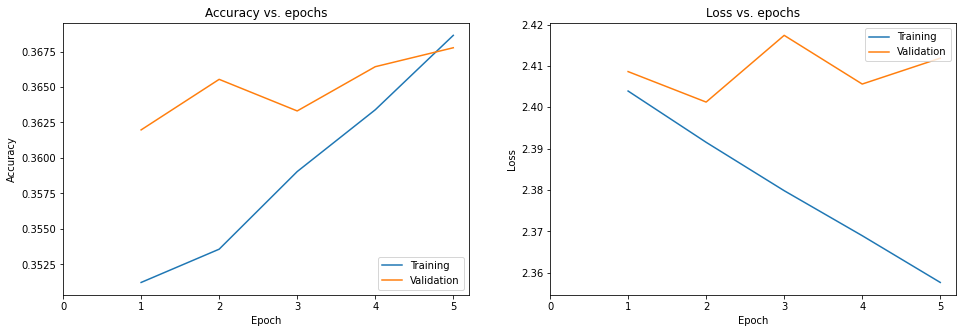

2021-08-10 06:29:26,572: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm
----------------------------------------evaluate----------------------------------------


2021-08-10 06:30:08,864: INFO: test loss:2.4119
2021-08-10 06:30:08,865: INFO: test accuracy:0.3678
2021-08-10 06:30:08,866: INFO: test sparse_top_k_categorical_accuracy:0.5788
2021-08-10 06:30:08,867: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:30:08,869: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:30:08,869: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:30:08,874: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:30:08,918: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets


2021-08-10 06:30:09,616: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets
2021-08-10 06:30:09,638: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator
2021-08-10 06:30:09,639: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:30:10,013: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


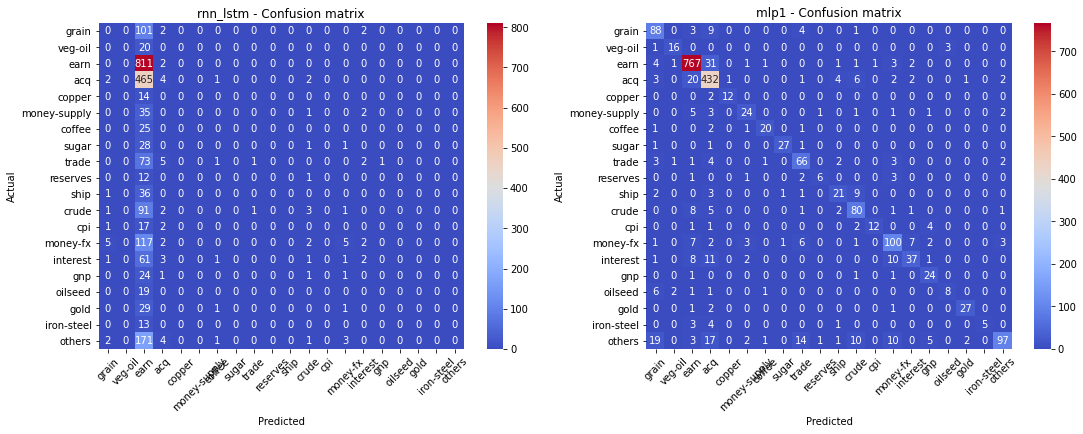

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
3,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611
4,embedding_ft,27646,36.1,1.0055,1.1345,0.7708,0.7311,0.8497,0.8206,0.9719,0.9579
5,sepcnn_ft,62258,58.4,1.0836,1.1973,0.7449,0.7275,0.8172,0.7961,0.9508,0.9462
6,sepcnn,2049358,77.1,0.8618,1.4052,0.7857,0.6986,0.8470,0.7760,0.9678,0.9180
7,rnn_lstm,3131846,258.0,2.3373,2.4119,0.3735,0.3678,0.5884,0.5788,0.5332,0.5185


In [44]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### rnn_lstm_ft

2021-08-10 06:30:20,656: INFO: model_params.rnn_lstm_ft.dropout=0.4
2021-08-10 06:30:20,657: INFO: model_params.rnn_lstm_ft.units=200
2021-08-10 06:30:20,658: INFO: max_features=10000
2021-08-10 06:30:20,659: INFO: model_params.rnn_lstm_ft.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
10000 300


2021-08-10 06:30:21,903: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:30:21,910: INFO: learning_rate=0.001
2021-08-10 06:30:21,911: INFO: model_params.rnn_lstm_ft.clip_value=None
2021-08-10 06:30:21,917: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm_ft
2021-08-10 06:30:21,920: INFO: model_params.rnn_lstm_ft.epochs=5
2021-08-10 06:30:21,920: INFO: use Mo

Model: "rnn_lstm_ft"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 400)          801600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 46)                9246      
Total params: 4,291,646
Trainable params: 1,291,646
Non-trainable params: 3,000,000
_____________________________________

2021-08-10 06:31:17,016: WARNING: Found untraced functions such as lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_11_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_10_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm_ft/assets


2021-08-10 06:31:19,382: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm_ft/assets


Epoch 2/5
280/280 [==============================] - 36s 128ms/step - loss: 2.4067 - accuracy: 0.3522 - sparse_top_k_categorical_accuracy: 0.5701 - val_loss: 2.4148 - val_accuracy: 0.3620 - val_sparse_top_k_categorical_accuracy: 0.5730
Epoch 3/5
280/280 [==============================] - 36s 128ms/step - loss: 2.4032 - accuracy: 0.3517 - sparse_top_k_categorical_accuracy: 0.5686 - val_loss: 2.4134 - val_accuracy: 0.3620 - val_sparse_top_k_categorical_accuracy: 0.5730
Epoch 4/5
280/280 [==============================] - 36s 127ms/step - loss: 2.3970 - accuracy: 0.3529 - sparse_top_k_categorical_accuracy: 0.5689 - val_loss: 2.4008 - val_accuracy: 0.3638 - val_sparse_top_k_categorical_accuracy: 0.5735
Epoch 5/5
280/280 [==============================] - 35s 126ms/step - loss: 2.3899 - accuracy: 0.3551 - sparse_top_k_categorical_accuracy: 0.5711 - val_loss: 2.4031 - val_accuracy: 0.3638 - val_sparse_top_k_categorical_accuracy: 0.5739


2021-08-10 06:33:42,975: INFO: finish training [elapsed time: 201.05 seconds]


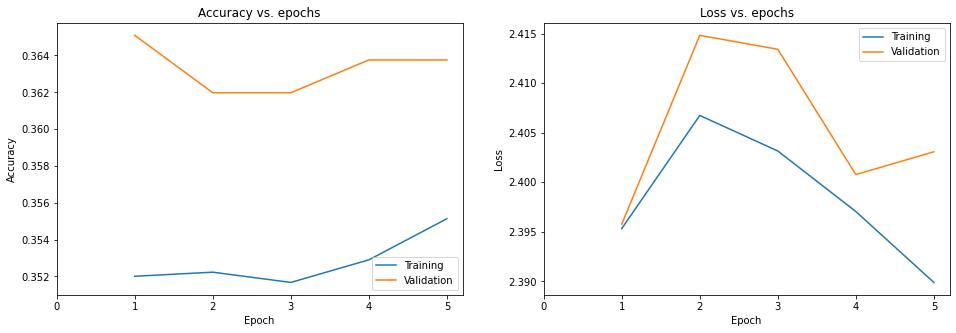

2021-08-10 06:33:43,333: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/rnn_lstm_ft
----------------------------------------evaluate----------------------------------------


2021-08-10 06:34:27,099: INFO: test loss:2.3958
2021-08-10 06:34:27,100: INFO: test accuracy:0.3651
2021-08-10 06:34:27,100: INFO: test sparse_top_k_categorical_accuracy:0.5770
2021-08-10 06:34:27,102: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:34:27,103: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:34:27,104: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:34:27,108: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:34:27,153: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets


2021-08-10 06:34:28,167: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets
2021-08-10 06:34:28,189: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator
2021-08-10 06:34:28,190: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:34:28,520: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


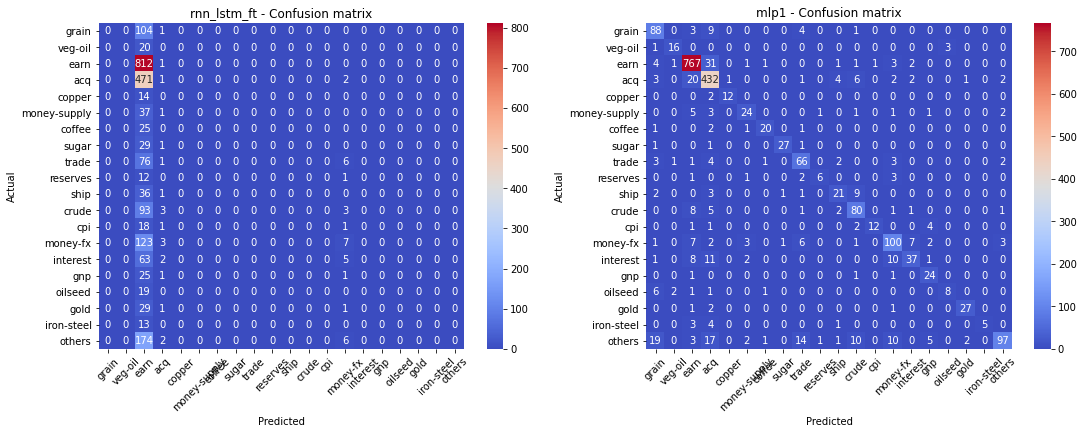

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
3,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611
4,embedding_ft,27646,36.1,1.0055,1.1345,0.7708,0.7311,0.8497,0.8206,0.9719,0.9579
5,sepcnn_ft,62258,58.4,1.0836,1.1973,0.7449,0.7275,0.8172,0.7961,0.9508,0.9462
6,sepcnn,2049358,77.1,0.8618,1.4052,0.7857,0.6986,0.8470,0.7760,0.9678,0.9180
7,rnn_lstm,3131846,258.0,2.3373,2.4119,0.3735,0.3678,0.5884,0.5788,0.5332,0.5185
8,rnn_lstm_ft,1291646,200.6,2.3812,2.3958,0.3569,0.3651,0.5750,0.5770,0.5167,0.5037


In [45]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm_ft',
                                        embedding_matrix=embedding_matrix_fasttext,
                                        is_embedding_trainable=False,
                 mask_zero=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

2021-08-10 06:34:38,727: INFO: model_params.pg_default.dropout=0.4
2021-08-10 06:34:38,728: INFO: model_params.pg_default.units=80
2021-08-10 06:34:38,728: INFO: max_features=10000
2021-08-10 06:34:38,729: INFO: model_params.pg_default.embedding_dim=300
2021-08-10 06:34:39,211: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 06:34:39,219: INFO: model_params.pg_default.learning_rate=0.0005
2021-08-10 06:34:39,220: INFO: model_params.pg_default.clip_value=

Model: "pg_default"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 500, 300)     3000000     input_16[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 500, 300)     0           embedding_6[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 500, 160)     183360      spatial_dropout1d[0][0]          
_________________________________________________________________________________________

2021-08-10 06:35:06,562: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:35:08,226: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 2/20
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 15s 52ms/step - loss: 1.3167 - accuracy: 0.7027 - sparse_top_k_categorical_accuracy: 0.7608 - val_loss: 1.2651 - val_accuracy: 0.7030 - val_sparse_top_k_categorical_accuracy: 0.7734


2021-08-10 06:35:32,077: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:35:33,670: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 3/20
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 1.0485 - accuracy: 0.7563 - sparse_top_k_categorical_accuracy: 0.8210 - val_loss: 1.1833 - val_accuracy: 0.7400 - val_sparse_top_k_categorical_accuracy: 0.8059


2021-08-10 06:35:57,270: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:35:58,835: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 4/20
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.8573 - accuracy: 0.8012 - sparse_top_k_categorical_accuracy: 0.8607 - val_loss: 1.0549 - val_accuracy: 0.7609 - val_sparse_top_k_categorical_accuracy: 0.8295


2021-08-10 06:36:21,939: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:36:23,517: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 5/20
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 48ms/step - loss: 0.7146 - accuracy: 0.8314 - sparse_top_k_categorical_accuracy: 0.8919 - val_loss: 1.0132 - val_accuracy: 0.7680 - val_sparse_top_k_categorical_accuracy: 0.8442


2021-08-10 06:36:46,874: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:36:48,421: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 6/20
Epoch 00006: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.6267 - accuracy: 0.8506 - sparse_top_k_categorical_accuracy: 0.9138 - val_loss: 0.9361 - val_accuracy: 0.7912 - val_sparse_top_k_categorical_accuracy: 0.8638


2021-08-10 06:37:10,589: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:37:12,142: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 7/20
Epoch 00007: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.5081 - accuracy: 0.8819 - sparse_top_k_categorical_accuracy: 0.9391 - val_loss: 0.9060 - val_accuracy: 0.7961 - val_sparse_top_k_categorical_accuracy: 0.8722


2021-08-10 06:37:35,766: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:37:37,329: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 8/20
Epoch 00008: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.4570 - accuracy: 0.8895 - sparse_top_k_categorical_accuracy: 0.9497 - val_loss: 0.8927 - val_accuracy: 0.8063 - val_sparse_top_k_categorical_accuracy: 0.8811


2021-08-10 06:38:00,410: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:38:01,943: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 9/20
Epoch 00009: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.3940 - accuracy: 0.9087 - sparse_top_k_categorical_accuracy: 0.9617 - val_loss: 0.8988 - val_accuracy: 0.8032 - val_sparse_top_k_categorical_accuracy: 0.8798
Epoch 10/20
Epoch 00010: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.3415 - accuracy: 0.9210 - sparse_top_k_categorical_accuracy: 0.9694 - val_loss: 0.8834 - val_accuracy: 0.8108 - val_sparse_top_k_categorical_accuracy: 0.8811


2021-08-10 06:38:37,375: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:38:39,688: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 11/20
Epoch 00011: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.3078 - accuracy: 0.9277 - sparse_top_k_categorical_accuracy: 0.9733 - val_loss: 0.9171 - val_accuracy: 0.8028 - val_sparse_top_k_categorical_accuracy: 0.8793
Epoch 12/20
Epoch 00012: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.2904 - accuracy: 0.9281 - sparse_top_k_categorical_accuracy: 0.9740 - val_loss: 0.8744 - val_accuracy: 0.8130 - val_sparse_top_k_categorical_accuracy: 0.8860


2021-08-10 06:39:15,072: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:39:16,698: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 13/20
Epoch 00013: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.2351 - accuracy: 0.9422 - sparse_top_k_categorical_accuracy: 0.9826 - val_loss: 0.8890 - val_accuracy: 0.8175 - val_sparse_top_k_categorical_accuracy: 0.8887


2021-08-10 06:39:40,032: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


2021-08-10 06:39:41,668: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default/assets


Epoch 14/20
Epoch 00014: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 48ms/step - loss: 0.2120 - accuracy: 0.9465 - sparse_top_k_categorical_accuracy: 0.9849 - val_loss: 0.9208 - val_accuracy: 0.8099 - val_sparse_top_k_categorical_accuracy: 0.8865
Epoch 15/20
Epoch 00015: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 48ms/step - loss: 0.2053 - accuracy: 0.9461 - sparse_top_k_categorical_accuracy: 0.9855 - val_loss: 0.8904 - val_accuracy: 0.8134 - val_sparse_top_k_categorical_accuracy: 0.8874
Epoch 16/20
Epoch 00016: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 13s 47ms/step - loss: 0.1925 - accuracy: 0.9473 - sparse_top_k_categorical_accuracy: 0.9878 - val_loss: 0.9237 - val_accuracy: 0.8099 - val_sparse_top_k_categorical_accuracy: 0.8905
Epoch 17/20
Epoch 00017: Still keep learning rate 0.0005 instead of 0.001
280/280 [====================

2021-08-10 06:41:15,339: INFO: finish training [elapsed time: 396.10 seconds]


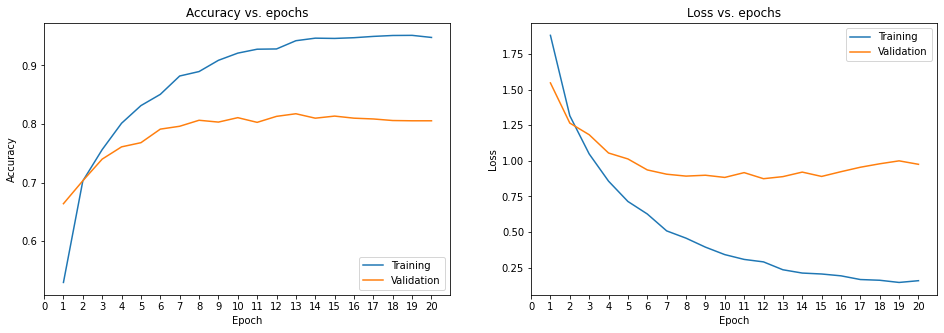

2021-08-10 06:41:15,815: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default
----------------------------------------evaluate----------------------------------------


2021-08-10 06:41:36,072: INFO: test loss:0.8890
2021-08-10 06:41:36,073: INFO: test accuracy:0.8175
2021-08-10 06:41:36,074: INFO: test sparse_top_k_categorical_accuracy:0.8887
2021-08-10 06:41:36,075: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:41:36,077: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 06:41:36,078: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 06:41:36,082: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 06:41:36,125: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets


2021-08-10 06:41:36,663: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets
2021-08-10 06:41:36,685: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator
2021-08-10 06:41:36,686: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:41:37,000: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


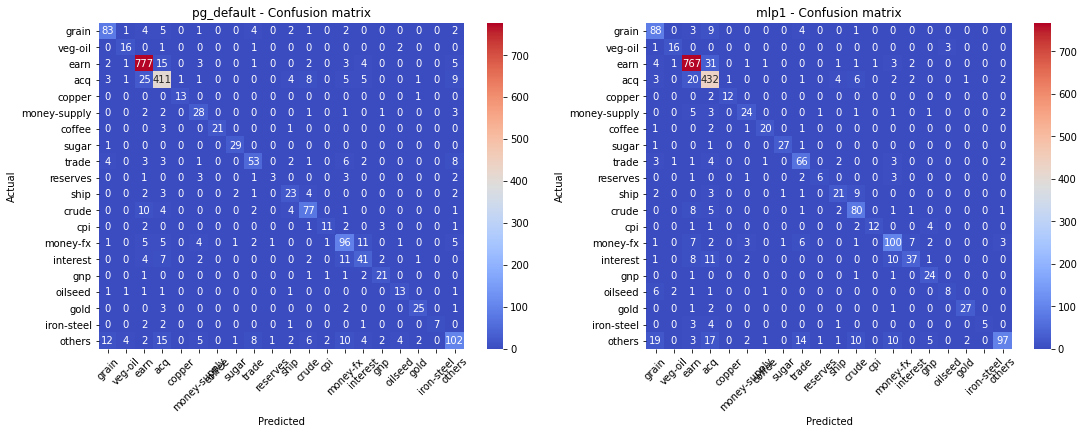

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
2,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
3,pg_default,3198126,395.6,0.1896,0.8890,0.9554,0.8175,0.9884,0.8887,0.9982,0.9614
4,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611
5,embedding_ft,27646,36.1,1.0055,1.1345,0.7708,0.7311,0.8497,0.8206,0.9719,0.9579
6,sepcnn_ft,62258,58.4,1.0836,1.1973,0.7449,0.7275,0.8172,0.7961,0.9508,0.9462
7,sepcnn,2049358,77.1,0.8618,1.4052,0.7857,0.6986,0.8470,0.7760,0.9678,0.9180
8,rnn_lstm,3131846,258.0,2.3373,2.4119,0.3735,0.3678,0.5884,0.5788,0.5332,0.5185
9,rnn_lstm_ft,1291646,200.6,2.3812,2.3958,0.3569,0.3651,0.5750,0.5770,0.5167,0.5037


In [46]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_default')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### pg_ft

2021-08-10 07:12:09,728: INFO: model_params.pg_ft.dropout=0.4
2021-08-10 07:12:09,729: INFO: model_params.pg_ft.units=80
2021-08-10 07:12:09,730: INFO: max_features=10000
2021-08-10 07:12:09,731: INFO: model_params.pg_ft.embedding_dim=300
2021-08-10 07:12:10,230: INFO: output_bias=[-5.09564467 -3.03455227 -4.79891276 -1.04496705 -1.52790615 -6.26976451
 -5.23177684 -6.33038913 -4.16850392 -4.48785734 -4.28269629 -3.13683111
 -5.21115756 -3.95548338 -5.84488132 -6.10724558 -3.00715329 -5.43941621
 -4.91332311 -2.79487941 -3.50826647 -4.49780767 -6.39492765 -5.38940579
 -4.97584347 -4.58118928 -5.92492402 -6.39492765 -5.23177684 -6.15853887
 -5.29631536 -5.43941621 -5.63724195 -6.70508258 -5.19095485 -6.80039276
 -5.21115756 -6.15853887 -6.15853887 -5.92492402 -5.51945892 -5.70178047
 -6.5380285  -6.05845542 -6.6180712  -6.2126061 ]
2021-08-10 07:12:10,238: INFO: model_params.pg_ft.learning_rate=0.0005
2021-08-10 07:12:10,238: INFO: model_params.pg_ft.clip_value=None
2021-08-10 07:12:10,

Model: "pg_ft"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 500, 300)     3000000     input_20[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 500, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 500, 160)     183360      spatial_dropout1d_2[0][0]        
______________________________________________________________________________________________

2021-08-10 07:12:33,625: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:12:35,277: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 2/20
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 1.3062 - accuracy: 0.6956 - sparse_top_k_categorical_accuracy: 0.7655 - val_loss: 1.2264 - val_accuracy: 0.7115 - val_sparse_top_k_categorical_accuracy: 0.7912


2021-08-10 07:12:55,391: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:12:58,031: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 3/20
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 1.1040 - accuracy: 0.7349 - sparse_top_k_categorical_accuracy: 0.8163 - val_loss: 1.0917 - val_accuracy: 0.7435 - val_sparse_top_k_categorical_accuracy: 0.8206


2021-08-10 07:13:18,185: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:13:19,827: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 4/20
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.9726 - accuracy: 0.7754 - sparse_top_k_categorical_accuracy: 0.8501 - val_loss: 0.9731 - val_accuracy: 0.7689 - val_sparse_top_k_categorical_accuracy: 0.8451


2021-08-10 07:13:39,937: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:13:43,096: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 5/20
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.8840 - accuracy: 0.7937 - sparse_top_k_categorical_accuracy: 0.8663 - val_loss: 0.9272 - val_accuracy: 0.7778 - val_sparse_top_k_categorical_accuracy: 0.8540


2021-08-10 07:14:03,239: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:14:04,881: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 6/20
Epoch 00006: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.8110 - accuracy: 0.8096 - sparse_top_k_categorical_accuracy: 0.8830 - val_loss: 0.8765 - val_accuracy: 0.7916 - val_sparse_top_k_categorical_accuracy: 0.8704


2021-08-10 07:14:26,077: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:14:27,750: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 7/20
Epoch 00007: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.7453 - accuracy: 0.8234 - sparse_top_k_categorical_accuracy: 0.8923 - val_loss: 0.8170 - val_accuracy: 0.8094 - val_sparse_top_k_categorical_accuracy: 0.8789


2021-08-10 07:14:47,827: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:14:49,441: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 8/20
Epoch 00008: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.6971 - accuracy: 0.8346 - sparse_top_k_categorical_accuracy: 0.9094 - val_loss: 0.7936 - val_accuracy: 0.8108 - val_sparse_top_k_categorical_accuracy: 0.8820


2021-08-10 07:15:10,890: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:15:12,561: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 9/20
Epoch 00009: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.6493 - accuracy: 0.8459 - sparse_top_k_categorical_accuracy: 0.9167 - val_loss: 0.7618 - val_accuracy: 0.8232 - val_sparse_top_k_categorical_accuracy: 0.8923


2021-08-10 07:15:32,490: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:15:34,120: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 10/20
Epoch 00010: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.6189 - accuracy: 0.8557 - sparse_top_k_categorical_accuracy: 0.9234 - val_loss: 0.7383 - val_accuracy: 0.8290 - val_sparse_top_k_categorical_accuracy: 0.8980


2021-08-10 07:15:55,458: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:15:57,105: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 11/20
Epoch 00011: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.5897 - accuracy: 0.8617 - sparse_top_k_categorical_accuracy: 0.9273 - val_loss: 0.7176 - val_accuracy: 0.8370 - val_sparse_top_k_categorical_accuracy: 0.9061


2021-08-10 07:16:17,237: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:16:18,855: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 12/20
Epoch 00012: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.5606 - accuracy: 0.8667 - sparse_top_k_categorical_accuracy: 0.9334 - val_loss: 0.7071 - val_accuracy: 0.8348 - val_sparse_top_k_categorical_accuracy: 0.9083
Epoch 13/20
Epoch 00013: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.5325 - accuracy: 0.8760 - sparse_top_k_categorical_accuracy: 0.9382 - val_loss: 0.6922 - val_accuracy: 0.8375 - val_sparse_top_k_categorical_accuracy: 0.9101


2021-08-10 07:16:49,981: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:16:51,612: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 14/20
Epoch 00014: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.5160 - accuracy: 0.8806 - sparse_top_k_categorical_accuracy: 0.9406 - val_loss: 0.6944 - val_accuracy: 0.8362 - val_sparse_top_k_categorical_accuracy: 0.9101
Epoch 15/20
Epoch 00015: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.4997 - accuracy: 0.8820 - sparse_top_k_categorical_accuracy: 0.9421 - val_loss: 0.6779 - val_accuracy: 0.8464 - val_sparse_top_k_categorical_accuracy: 0.9110


2021-08-10 07:17:21,825: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:17:23,458: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 16/20
Epoch 00016: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.5058 - accuracy: 0.8791 - sparse_top_k_categorical_accuracy: 0.9400 - val_loss: 0.6916 - val_accuracy: 0.8402 - val_sparse_top_k_categorical_accuracy: 0.9087
Epoch 17/20
Epoch 00017: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.4605 - accuracy: 0.8914 - sparse_top_k_categorical_accuracy: 0.9480 - val_loss: 0.6666 - val_accuracy: 0.8446 - val_sparse_top_k_categorical_accuracy: 0.9141
Epoch 18/20
Epoch 00018: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 36ms/step - loss: 0.4471 - accuracy: 0.8935 - sparse_top_k_categorical_accuracy: 0.9489 - val_loss: 0.6713 - val_accuracy: 0.8451 - val_sparse_top_k_categorical_accuracy: 0.9110
Epoch 19/20
Epoch 00019: Still keep learning rate 0.0005 instead of 0.001
280/280 [====================

2021-08-10 07:18:15,060: WARNING: Found untraced functions such as gru_cell_19_layer_call_and_return_conditional_losses, gru_cell_19_layer_call_fn, gru_cell_20_layer_call_and_return_conditional_losses, gru_cell_20_layer_call_fn, gru_cell_19_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


2021-08-10 07:18:16,708: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft/assets


Epoch 20/20
Epoch 00020: Still keep learning rate 0.0005 instead of 0.001
280/280 [==============================] - 10s 37ms/step - loss: 0.4148 - accuracy: 0.9020 - sparse_top_k_categorical_accuracy: 0.9557 - val_loss: 0.6684 - val_accuracy: 0.8446 - val_sparse_top_k_categorical_accuracy: 0.9145


2021-08-10 07:18:27,841: INFO: finish training [elapsed time: 377.59 seconds]


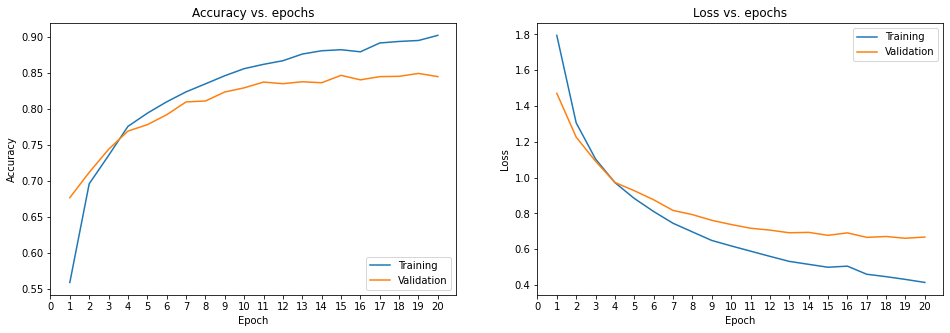

2021-08-10 07:18:28,395: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft
----------------------------------------evaluate----------------------------------------


2021-08-10 07:18:49,573: INFO: test loss:0.6615
2021-08-10 07:18:49,574: INFO: test accuracy:0.8491
2021-08-10 07:18:49,574: INFO: test sparse_top_k_categorical_accuracy:0.9163
2021-08-10 07:18:49,576: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 07:18:49,577: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json
2021-08-10 07:18:49,578: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-08-10 07:18:49,582: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-08-10 07:18:49,627: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets


2021-08-10 07:18:50,232: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.layer/assets
2021-08-10 07:18:50,256: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator
2021-08-10 07:18:50,257: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-08-10 07:18:50,606: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator


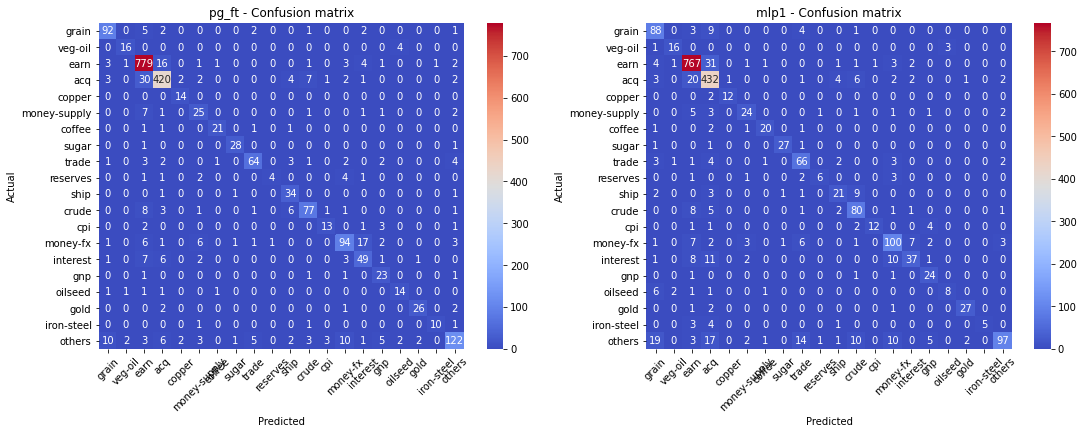

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,pg_ft,198126,377.1,0.3826,0.6615,0.9078,0.8491,0.9579,0.9163,0.9938,0.9760
2,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
3,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
4,pg_default,3198126,395.6,0.1896,0.8890,0.9554,0.8175,0.9884,0.8887,0.9982,0.9614
5,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611
6,embedding_ft,27646,36.1,1.0055,1.1345,0.7708,0.7311,0.8497,0.8206,0.9719,0.9579
7,sepcnn_ft,62258,58.4,1.0836,1.1973,0.7449,0.7275,0.8172,0.7961,0.9508,0.9462
8,sepcnn,2049358,77.1,0.8618,1.4052,0.7857,0.6986,0.8470,0.7760,0.9678,0.9180
9,rnn_lstm,3131846,258.0,2.3373,2.4119,0.3735,0.3678,0.5884,0.5788,0.5332,0.5185
10,rnn_lstm_ft,1291646,200.6,2.3812,2.3958,0.3569,0.3651,0.5750,0.5770,0.5167,0.5037


In [55]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_ft', 
                                              embedding_matrix=embedding_matrix_fasttext, 
                                              is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

## 评估

### 最佳模型

In [56]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-08-10 07:18:59,352: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters
2021-08-10 07:18:59,353: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/results.json


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,pg_ft,198126,377.1,0.3826,0.6615,0.9078,0.8491,0.9579,0.9163,0.9938,0.9760
2,mlp1,2572078,26.7,0.3528,0.7201,0.9125,0.8286,0.9628,0.9065,0.9946,0.9769
3,embedding,2018446,67.8,0.2454,0.7441,0.9412,0.8259,0.9804,0.9016,0.9976,0.9718
4,pg_default,3198126,395.6,0.1896,0.8890,0.9554,0.8175,0.9884,0.8887,0.9982,0.9614
5,mlp2,2572078,23.3,0.3638,1.0440,0.9001,0.7707,0.9602,0.8531,0.9974,0.9611
6,embedding_ft,27646,36.1,1.0055,1.1345,0.7708,0.7311,0.8497,0.8206,0.9719,0.9579
7,sepcnn_ft,62258,58.4,1.0836,1.1973,0.7449,0.7275,0.8172,0.7961,0.9508,0.9462
8,sepcnn,2049358,77.1,0.8618,1.4052,0.7857,0.6986,0.8470,0.7760,0.9678,0.9180
9,rnn_lstm,3131846,258.0,2.3373,2.4119,0.3735,0.3678,0.5884,0.5788,0.5332,0.5185
10,rnn_lstm_ft,1291646,200.6,2.3812,2.3958,0.3569,0.3651,0.5750,0.5770,0.5167,0.5037


2021-08-10 07:18:59,431: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_ft
2021-08-10 07:19:05,548: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


2021-08-10 07:19:05,915: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-08-10 07:19:05,918: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp1
2021-08-10 07:19:06,259: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_preproess.generator
2021-08-10 07:19:06,343: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/embedding
2021-08-10 07:19:06,657: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


2021-08-10 07:19:07,007: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-08-10 07:19:07,012: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/pg_default
2021-08-10 07:19:14,277: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/sequence_map.generator


2021-08-10 07:19:14,654: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-08-10 07:19:14,658: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/mlp2
2021-08-10 07:19:14,995: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/reuters/reuters_0721_p100/ngram_map.generator


2021-08-10 07:19:15,321: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


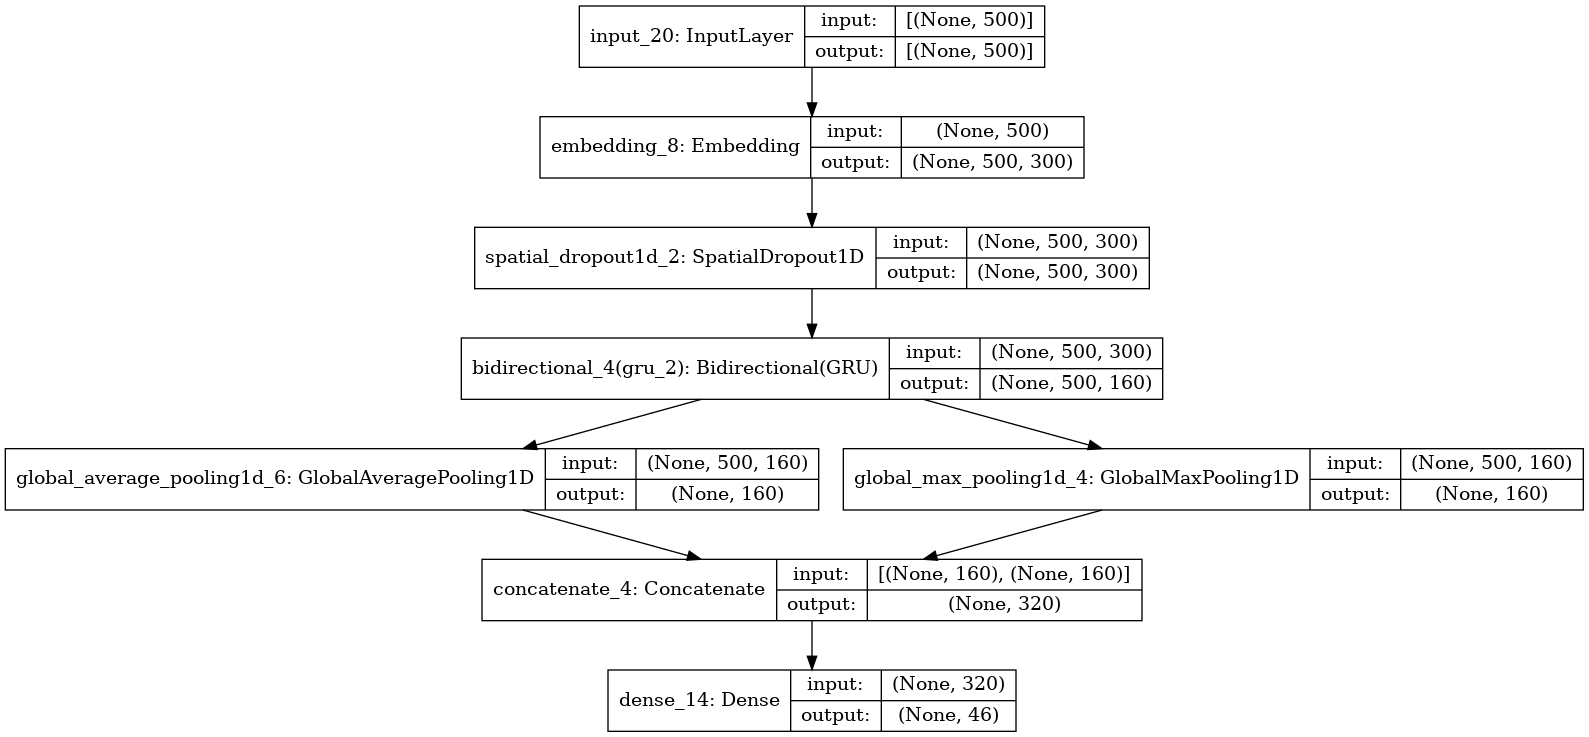

In [57]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

----------------------------------------1. money-supply----------------------------------------
treasury balances at the federal reserve rose on feb 27 to 3 482 billion dlrs from 1 538 billion dlrs the previous business day the treasury said in its latest budget statement balances in tax and loan note accounts fell to 21 334 billion dlrs from 25 164 billion dlrs on the same respective days the treasury's operating cash balance totaled 24 816 billion dlrs on feb 27 compared with 26 702 billion dlrs on feb 26 reuter 3


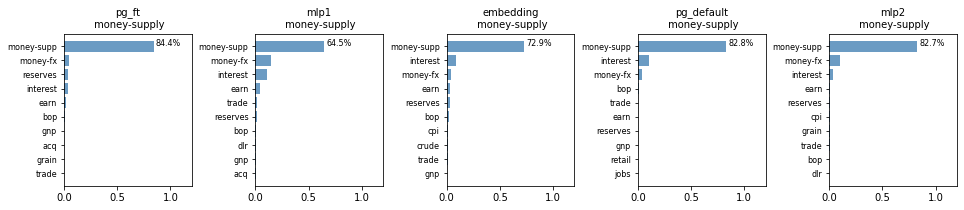

----------------------------------------2. earn----------------------------------------
periods ended feb 28 shr 22 cts vs 30 cts net 549 000 vs 747 000 sales 8 4 mln vs nine mln avg shrs 2 550 784 vs 2 468 964 nine mths shr 69 cts vs 63 cts net 1 749 000 vs 1 554 000 sales 23 6 mln vs 21 3 mln avg shrs 2 543 711 vs 2 453 520 reuter 3


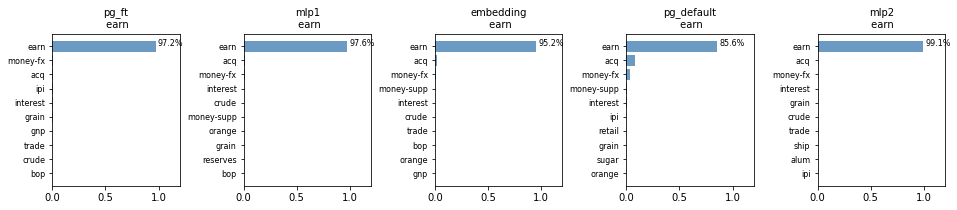

----------------------------------------3. earn----------------------------------------
electrospace systems inc said it was ordered by the u s army to immediately proceed with the design and production of a computer based control system for the army's tactical voice and data communications network in a contract potentially worth 101 mln dlrs it said the order followed a favorable ruling by the general accounting office on two protests that earlier caused a stop work order on the 26 8 mln dlr contract awarded last september it said that order covers 59 mobile shelter based systems and 44 remote terminals with options for 279 mobile units and 178 remote units for a total of 101 mln dlrs reuter 3


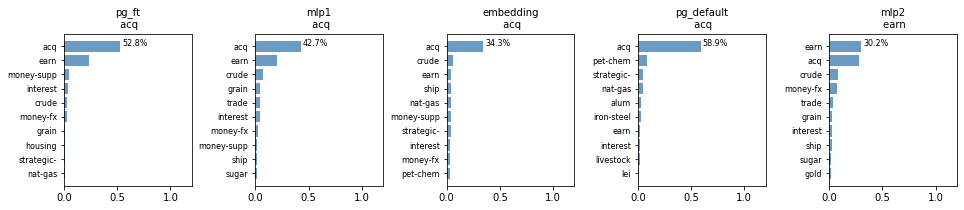

----------------------------------------4. earn----------------------------------------
shr loss two cts vs profit two cts net profit 253 000 vs profit 356 000 revs 17 5 mln vs 12 3 mln nine mths shr profit one cent vs profit 21 cts net profit 628 000 vs profit 2 921 000 revs 54 9 mln vs 36 0 mln note 1987 qtr and nine mths includes gain 106 000 dlrs or one cent per share and 846 000 dlrs or six cts per share respectively from utilization of tax loss carryforward 1986 qtr and nine mths includes gain 178 000 dlrs or one cent per share and gain 810 000 dlrs or six cts per share respectively from utilization of tax loss carryforward 1987 nine mths includes loss 1 519 000 dlrs or 11 cts per share from early extinguishment of debt reuter 3


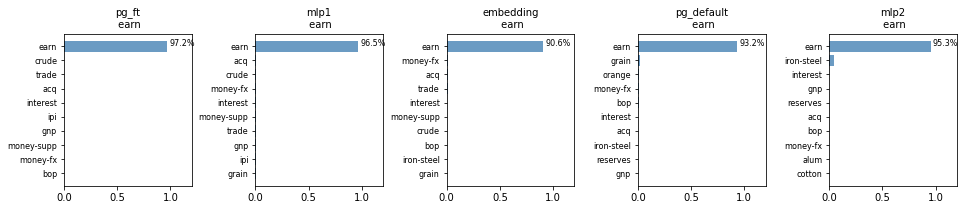

----------------------------------------5. ipi----------------------------------------
hungary's economy and hard currency trade have failed so far this year to reverse a two year unfavourable trend the official hungarian news agency mti said industrial production in january and february was only 1 3 pct up on the same 1986 period mti said while hard currency exports fell six pct as imports rose 10 pct hungary's hard currency trade fell into a deficit of 539 4 mln dlrs last year from a surplus of 295 3 mln in 1985 and 1 2 billion in 1984 mti quoted a government spokesman saying last december's wage freeze decree would expire on april 1 as envisaged gross domestic product grew a sluggish one pct in 1986 after stagnating in 1985 and growing 2 6 pct in 1984 reuter 3


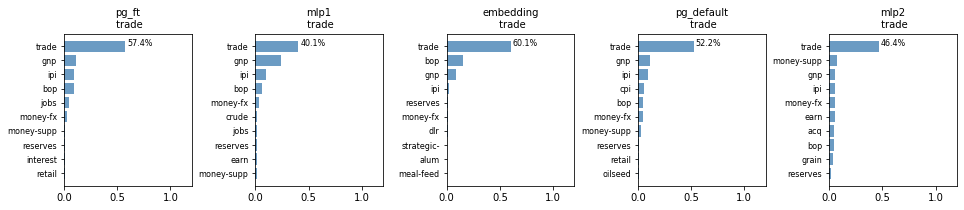

In [58]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=False) 

<class 'list'>
----------------------------------------1. interest----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


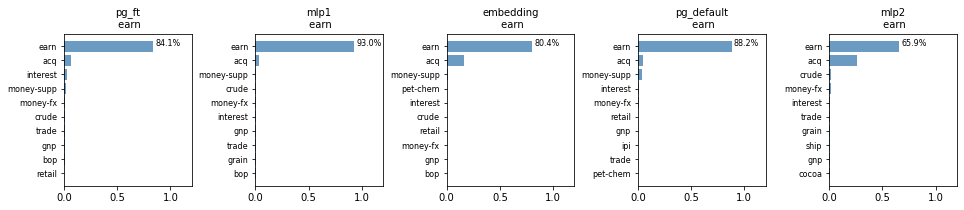

----------------------------------------2. acq----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


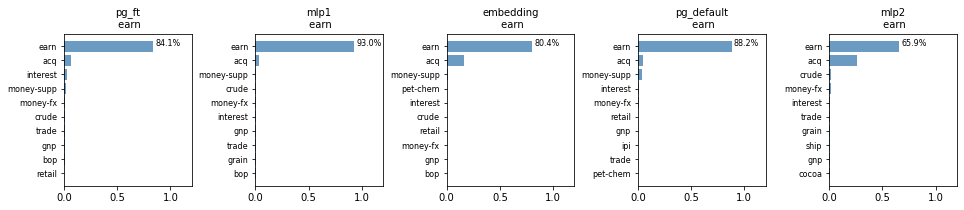

----------------------------------------3. earn----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


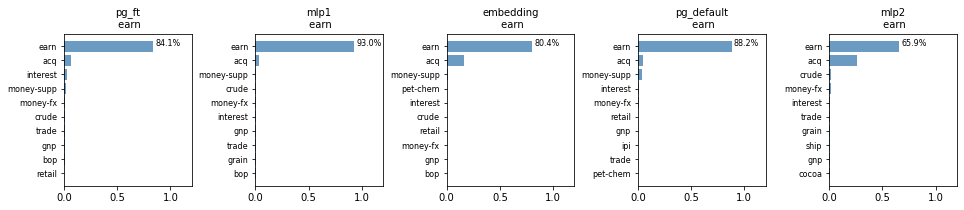

----------------------------------------4. strategic-metal----------------------------------------
philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yulo told reuters a survey during the current milling season which ends next month showed the 1986 87 estimate would almost certainly be met he said at least 1 2 mln tonnes of the 1987 88 crop would be earmarked for domestic consumption yulo said about 130 000 tonnes would be set aside for the u s sugar quota 150 000 tonnes for strategic reserves and 50 000 tonnes would be sold on the world market he said if the government approved a long standing sra recommendation to manufacture ethanol the project would take up another 150 000 tonnes slightly raising the target the government for its own reasons has been delaying approval of the project but we expect it to come through by july yulo

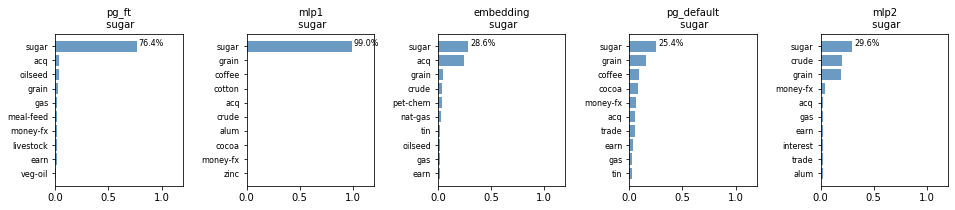

----------------------------------------5. dlr----------------------------------------
the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3


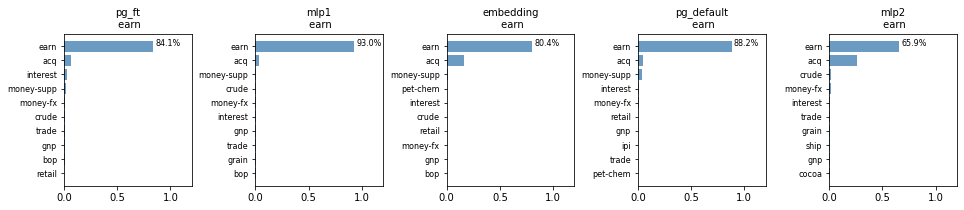

In [59]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [60]:
results = best_predictor.evaluate(test_texts, test_labels)
print(results)

predictions = best_predictor.predict(test_texts)
print(predictions.shape)

{'loss': 0.6615263819694519, 'accuracy': 0.8490650057792664, 'mae': 16.448423385620117}
(2246, 46)


In [61]:
top1_predictions = best_predictor.predict_top_k(test_texts, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
cocoa,0.900000,0.750000,0.818182
grain,0.821429,0.876190,0.847926
veg-oil,0.800000,0.800000,0.800000
earn,0.911111,0.958180,0.934053
acq,0.907127,0.886076,0.896478
wheat,0.000000,0.000000,0.000000
copper,0.777778,1.000000,0.875000
housing,1.000000,0.333333,0.500000
money-supply,0.581395,0.657895,0.617284
coffee,0.875000,0.840000,0.857143


----------------------------------------------------------------------------------------------------
                 precision    recall  f1-score   support

          cocoa     0.9000    0.7500    0.8182        12
          grain     0.8214    0.8762    0.8479       105
        veg-oil     0.8000    0.8000    0.8000        20
           earn     0.9111    0.9582    0.9341       813
            acq     0.9071    0.8861    0.8965       474
          wheat     0.0000    0.0000    0.0000         5
         copper     0.7778    1.0000    0.8750        14
        housing     1.0000    0.3333    0.5000         3
   money-supply     0.5814    0.6579    0.6173        38
         coffee     0.8750    0.8400    0.8571        25
          sugar     0.9032    0.9333    0.9180        30
          trade     0.8649    0.7711    0.8153        83
       reserves     0.8000    0.3077    0.4444        13
           ship     0.6800    0.9189    0.7816        37
         cotton     1.0000    1.0000    1.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


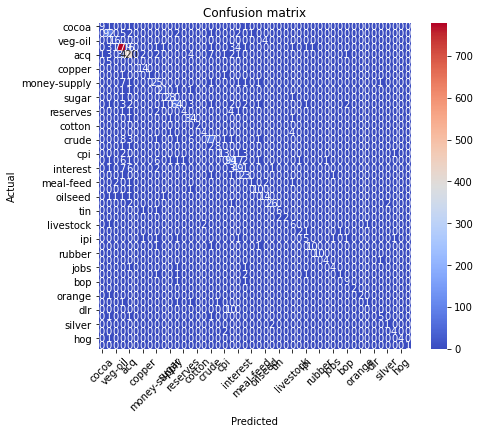

In [63]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)